## This version has the norm and not norm and log all in one

## TODO: run umap instead of tsne
add perplexity as parameter and output

In [1]:
se_cells_meta_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/se_cells_meta.tsv"
sample_names = "preB,postB"
outdir="/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/clone_clust_umap"

In [2]:
samples = sample_names.split(",")
samples

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join, basename, exists
import click
from glob import glob
from mplh.fig_utils import helper_save as hs
from mplh.cluster_help import plot_cluster as pc
import logging
import os
from matplotlib import rcParams
#import scanpy
#rcParams['lines.markersize'] = 10
import numpy as np
from sklearn.manifold import TSNE

In [4]:
np.random.seed(42)

In [5]:
if not exists(outdir):
    os.mkdir(outdir)

In [6]:
cells_meta = pd.read_csv(se_cells_meta_f,sep="\t")
cells_meta = cells_meta[["condition", "lineage", "name", "donor", "seurat_clusters"]]
cells_meta

condition lineage  name donor  seurat_clusters
preB_AAACGAAGTCACTCTC-1       preB      10  0_10     0                0
preB_AAACGAAGTCCCTAAA-1       preB      33  3_33     3                8
preB_AAACGAAGTCTGTGTA-1       preB      20  1_20     1                2
preB_AAACTCGCAACTCGTA-1       preB       0   2_0     2                8
preB_AAACTCGCAGAACGAC-1       preB       9   2_9     2                6
...                            ...     ...   ...   ...              ...
postB_TTTGGTTTCGAGGTCC-1     postB       9   3_9     3                3
postB_TTTGGTTTCTAGCTGA-1     postB      21  3_21     3                0
postB_TTTGTGTCACAGTTCA-1     postB       4   1_4     1                0
postB_TTTGTGTGTGCCGGTT-1      None    None  None  None                4
postB_TTTGTGTTCCATGACA-1     postB      24  0_24     0                9

[4112 rows x 5 columns]

## Get counts
(and add 1 to all for pseudo)

In [8]:
counts = cells_meta.groupby(["condition","name","donor", "seurat_clusters"]).size().reset_index().rename({0:"count"},axis=1)
counts = counts[~(counts["name"]=="None")]
counts


se_clust = np.unique(counts["seurat_clusters"].values)
clones = np.unique(counts["name"].values)

for name in clones:
    donor = name.split("_")[0]
    for clust in se_clust:
        for sample in samples:
            curr = counts.loc[(counts["name"]==name) & (counts["condition"]==sample) 
                          & (counts["seurat_clusters"]==clust) ]
            if len(curr) == 0:
                # Add to counts
                
                counts.append(pd.Series({"condition":sample, "name":name, "seurat_clusters":clust,"donor": donor,
                          "count": 0, "ID": f"{name}_{sample}"}), ignore_index=True)
counts        

counts["count"]+=1

In [9]:
counts["batch"] = counts.groupby(["donor", "condition"]).transform(np.sum)["count"]
counts["log"] = np.log2(counts["count"])

counts["norm"] = counts["log"]/counts["batch"]
counts["ID"] = counts["name"] + "_" + counts["condition"]
meta = counts[~(counts.duplicated(subset="ID"))][["ID", "condition", "donor", "name"]].set_index("ID")

clust_clones_counts_log = counts.pivot(columns="seurat_clusters",values="log", index="ID").fillna(0)
clust_clones_counts_norm = counts.pivot(columns="seurat_clusters",values="norm", index="ID").fillna(0)
clust_clones_counts = counts.pivot(columns="seurat_clusters",values="count", index="ID").fillna(0)

clust_clones_counts

seurat_clusters    0     1     2     3    4     5    6     7    8    9    10
ID                                                                          
0_0_postB         6.0   2.0   7.0   2.0  2.0   2.0  3.0   3.0  0.0  0.0  0.0
0_0_preB          4.0   6.0   2.0   4.0  4.0   4.0  2.0   4.0  0.0  0.0  0.0
0_10_postB        4.0   3.0   2.0   2.0  0.0   0.0  0.0   2.0  0.0  2.0  0.0
0_10_preB         4.0   3.0   0.0   4.0  2.0   4.0  2.0   2.0  0.0  0.0  0.0
0_11_postB        0.0   8.0   0.0   0.0  4.0   0.0  0.0   5.0  4.0  0.0  0.0
...               ...   ...   ...   ...  ...   ...  ...   ...  ...  ...  ...
3_5_postB        16.0  16.0  10.0  22.0  4.0   7.0  5.0   2.0  5.0  2.0  0.0
3_6_preB         12.0  15.0  12.0   7.0  9.0   4.0  3.0  12.0  4.0  6.0  0.0
3_7_postB        13.0  15.0   9.0  12.0  7.0  14.0  2.0   3.0  2.0  3.0  0.0
3_8_postB        15.0  17.0   6.0  17.0  8.0   4.0  6.0   3.0  2.0  0.0  2.0
3_9_postB        17.0  11.0   3.0  14.0  9.0   6.0  7.0   2.0  7.0  0.0  0.0

[299 rows x 11 columns]

## Run t-sne for norm and not norm

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


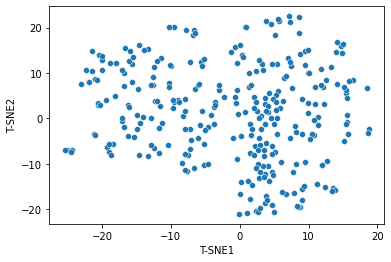

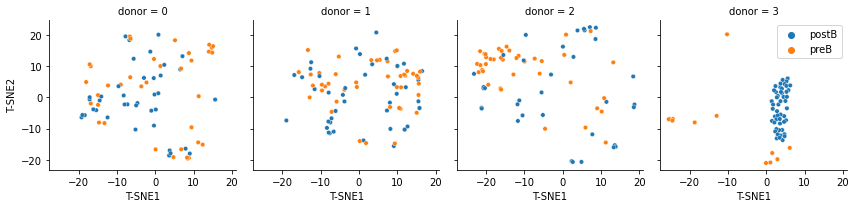

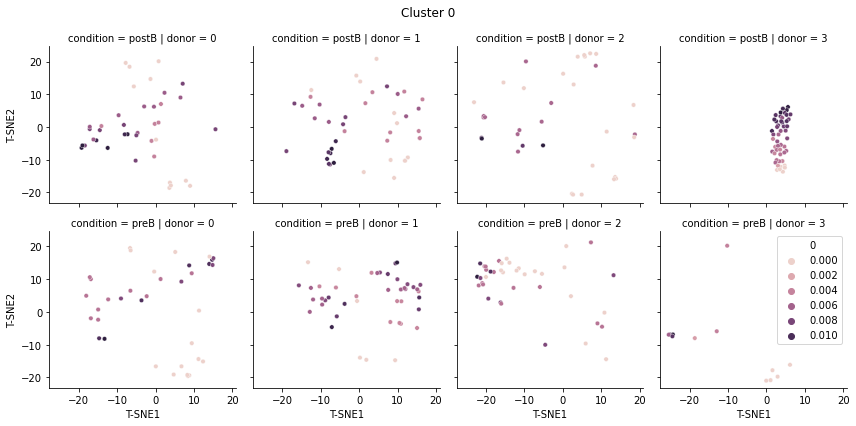

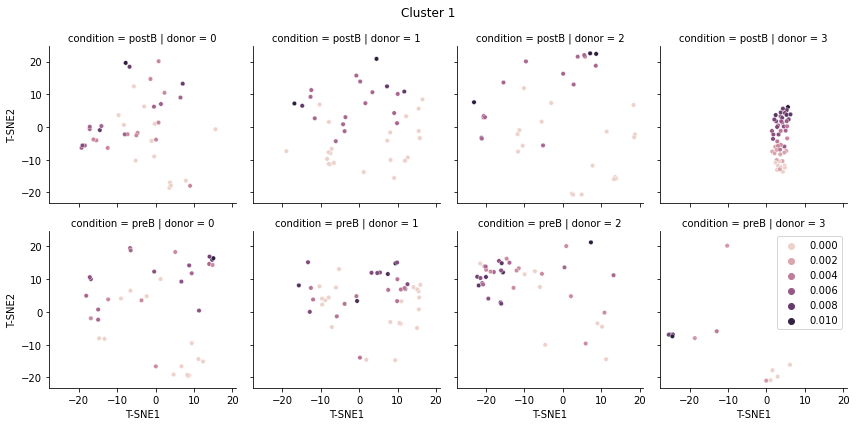

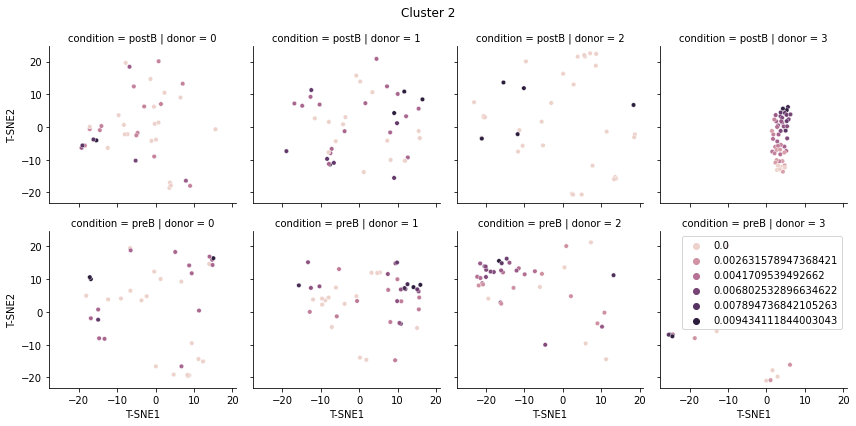

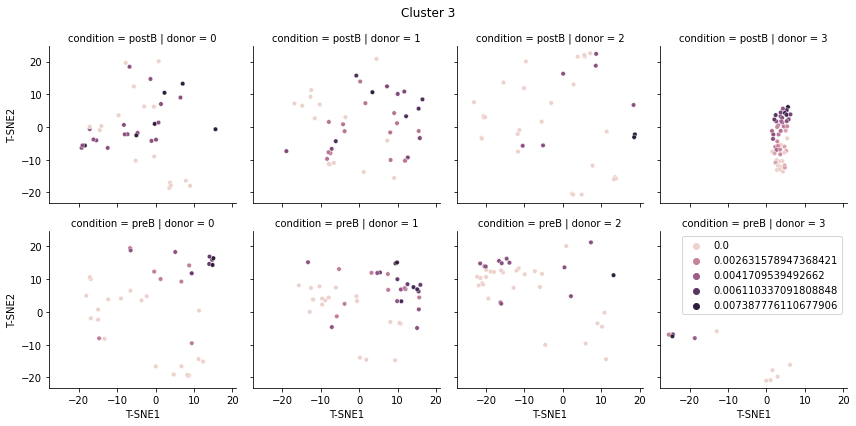

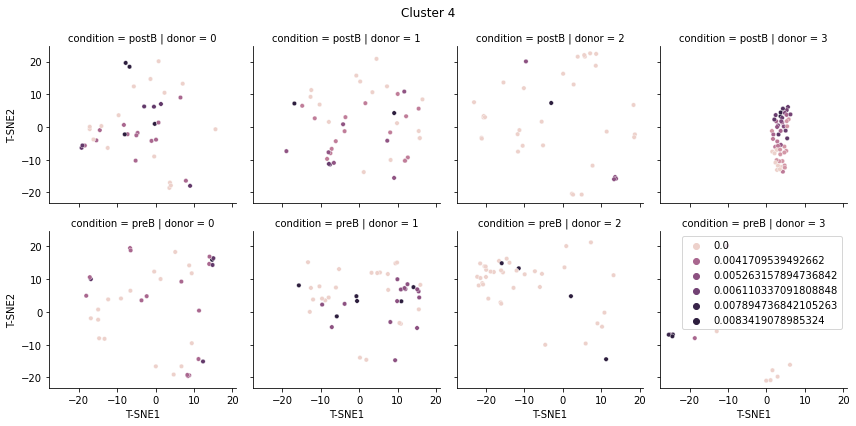

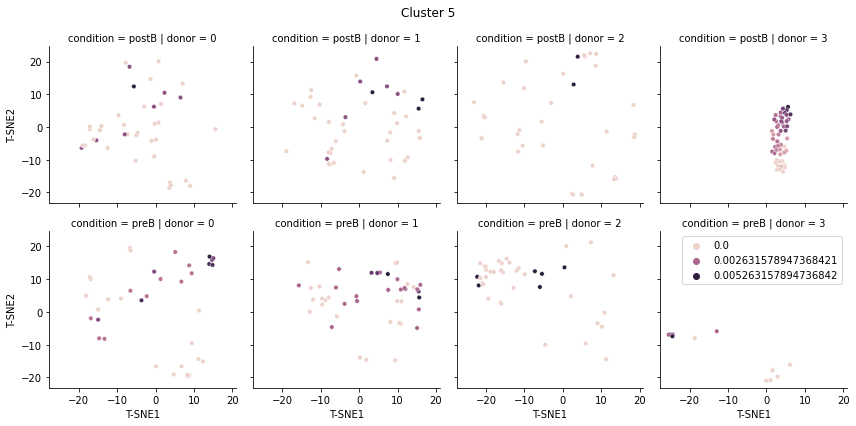

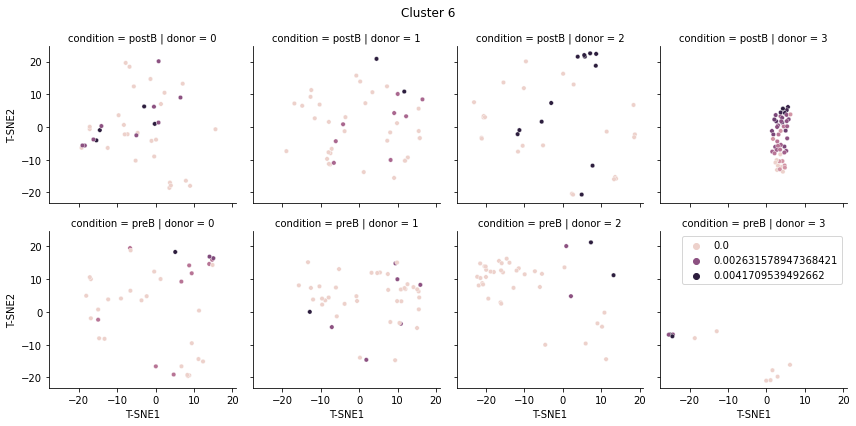

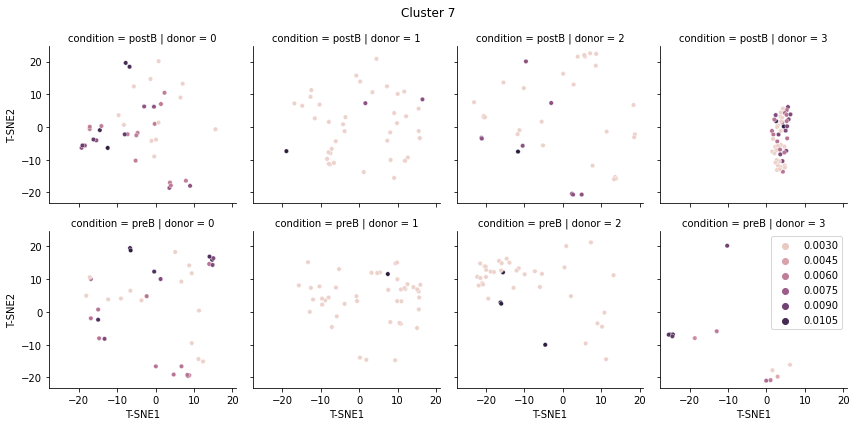

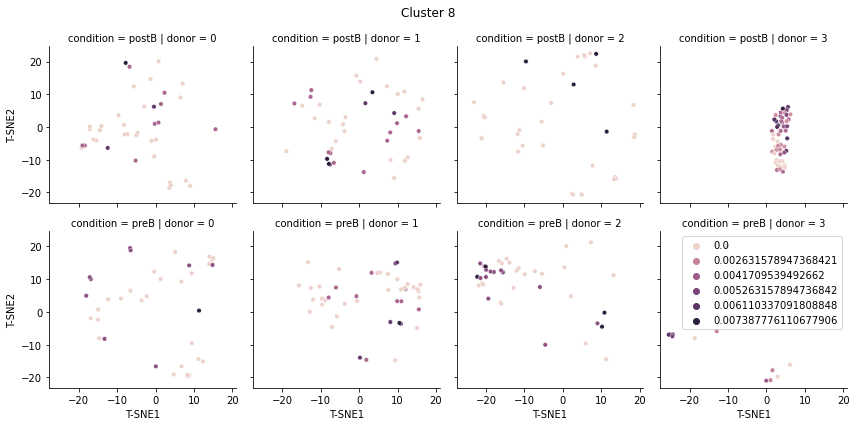

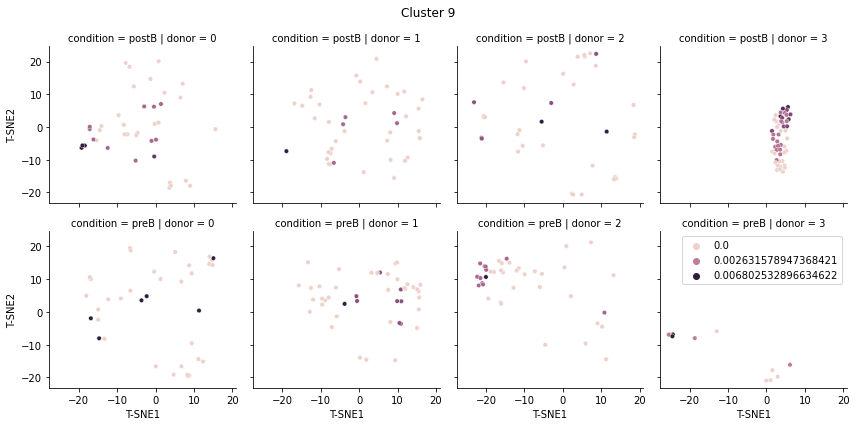

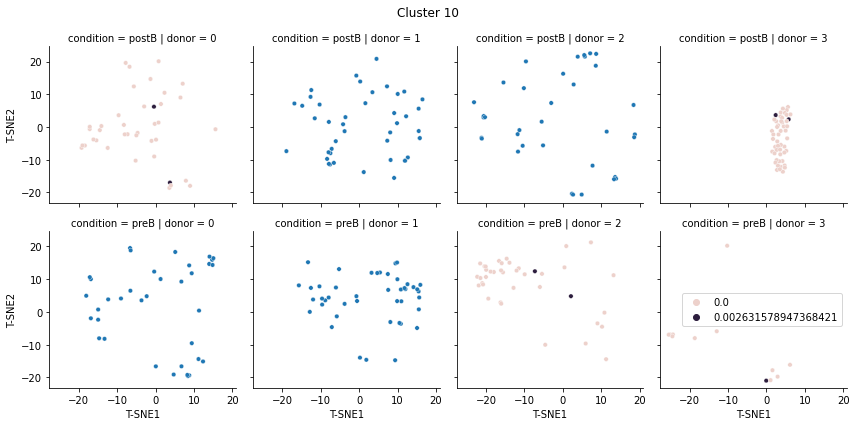

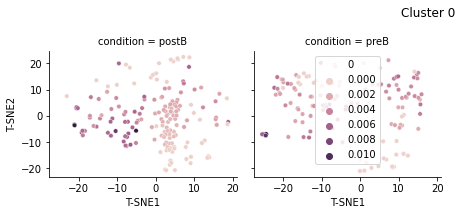

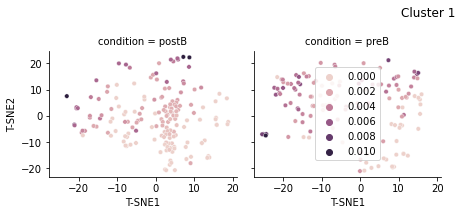

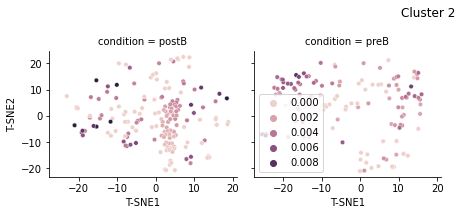

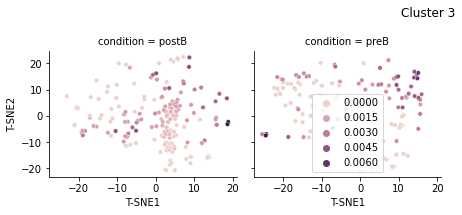

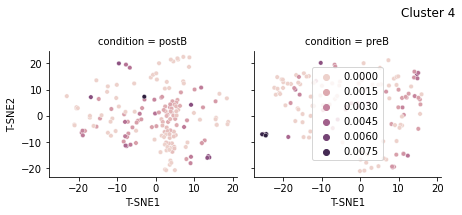

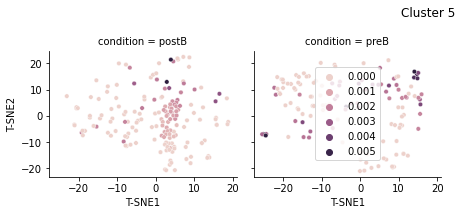

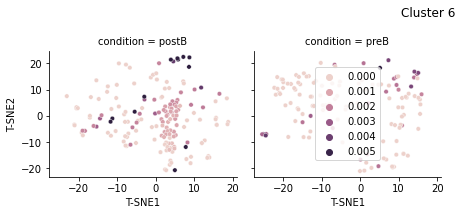

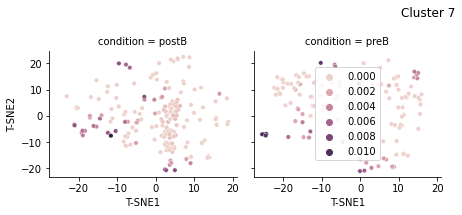

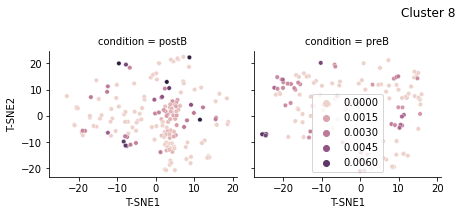

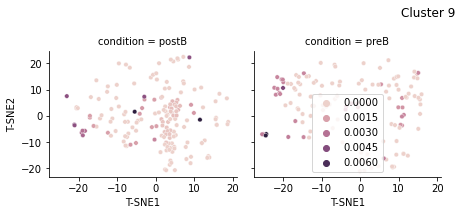

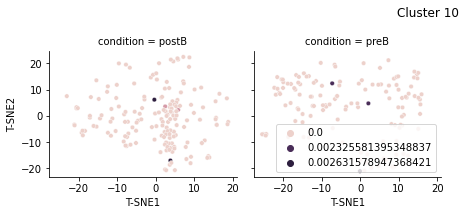

In [10]:
%matplotlib inline
norm_outdir = join(outdir, "norm")

if not exists(norm_outdir):
    os.mkdir(norm_outdir)
    
X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=20,
                  init='random').fit_transform(clust_clones_counts_norm.values)

tsne_df = pd.DataFrame(X_embedded, index=clust_clones_counts_norm.index).rename({0:"T-SNE1",1:"T-SNE2"}, axis=1)
tsne_df

tsne_meta_df = pd.merge(tsne_df, meta, left_index=True, right_index=True)
sns.scatterplot(data=tsne_df, x="T-SNE1", y="T-SNE2")
tsne_meta_df

g = sns.FacetGrid(tsne_meta_df, col="donor",col_wrap=4)
g.map_dataframe(sns.scatterplot, x="T-SNE1", y="T-SNE2", hue="condition", s=20)
plt.legend()
plt.savefig(join(norm_outdir, "umap.pdf"))

tsne_meta_features_df = pd.merge(tsne_meta_df, clust_clones_counts_norm, left_index=True, right_index=True)
tsne_meta_features_df


for c in clust_clones_counts_norm.columns:
    g = sns.FacetGrid(tsne_meta_features_df, row="condition", col="donor")
    g.map_dataframe(sns.scatterplot, x="T-SNE1", y="T-SNE2", hue=c, s=20)
    plt.suptitle(f"Cluster {c}")
    plt.tight_layout()
    plt.legend()


for c in clust_clones_counts_norm.columns:
    g = sns.FacetGrid(tsne_meta_features_df, col="condition", col_wrap=4)
    g.map_dataframe(sns.scatterplot, x="T-SNE1", y="T-SNE2", hue=c, s=20)
    plt.suptitle(f"Cluster {c}")
    plt.tight_layout()
    plt.legend()
    plt.savefig(join(norm_outdir, f"clust_{c}.png"))
    
    

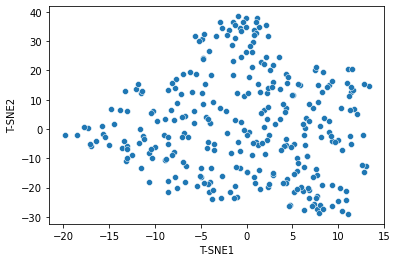

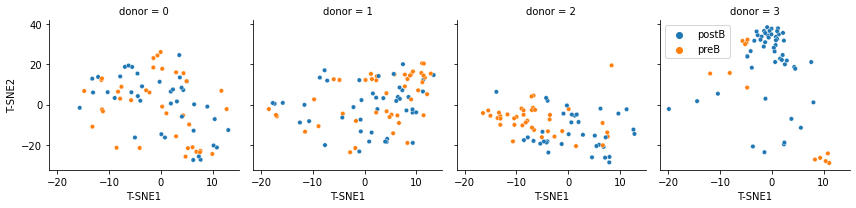

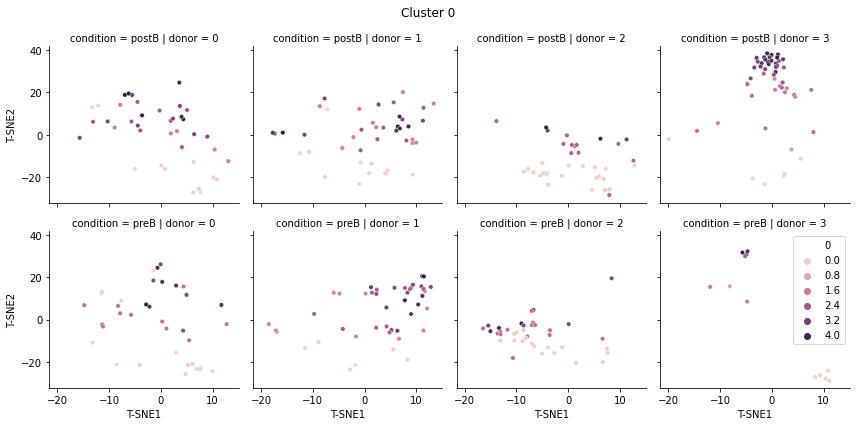

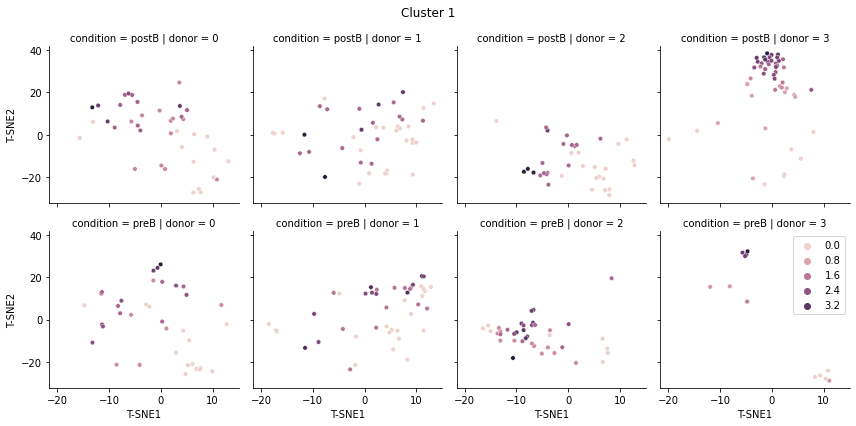

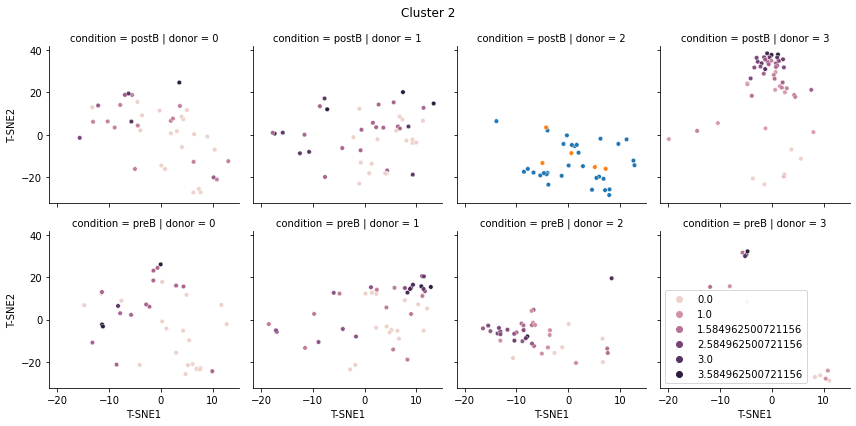

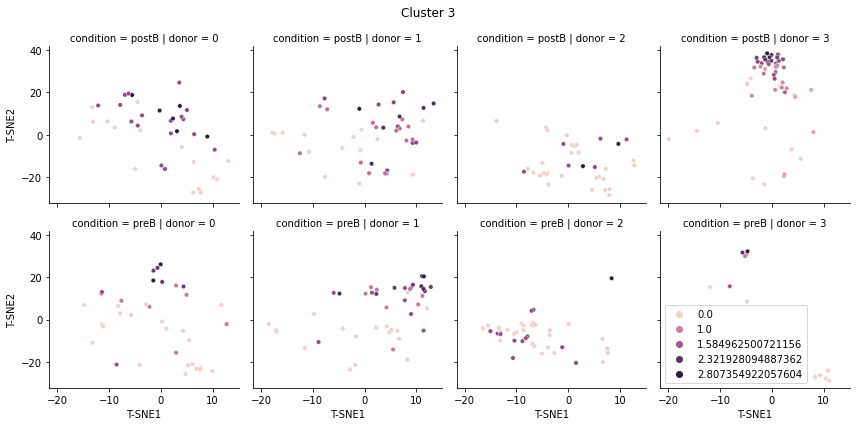

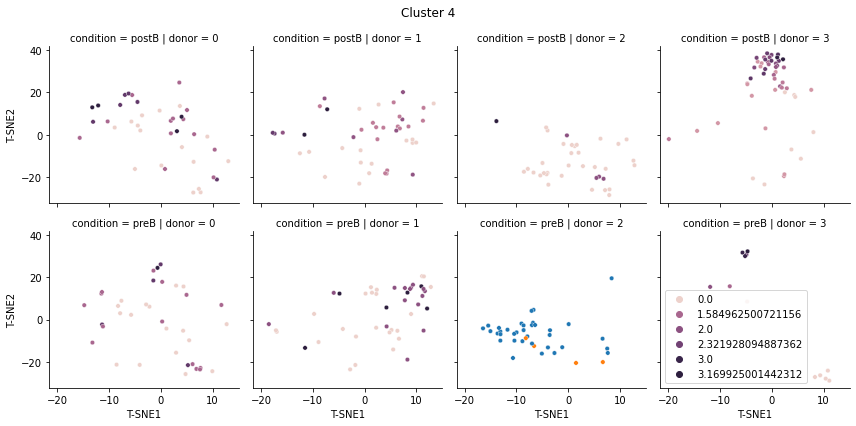

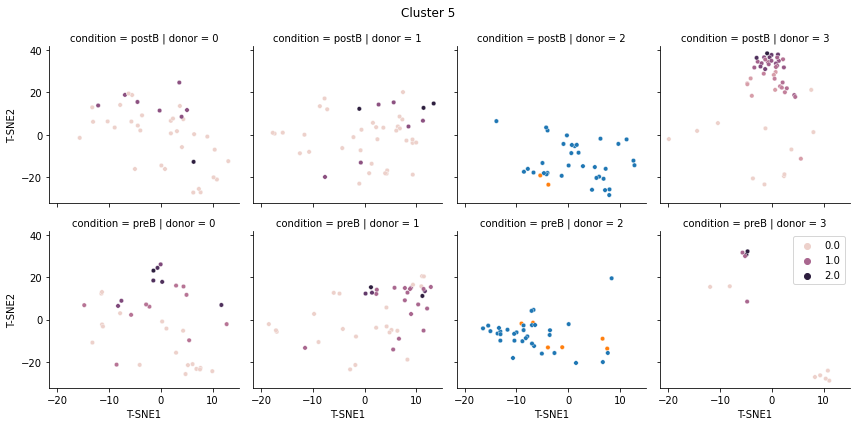

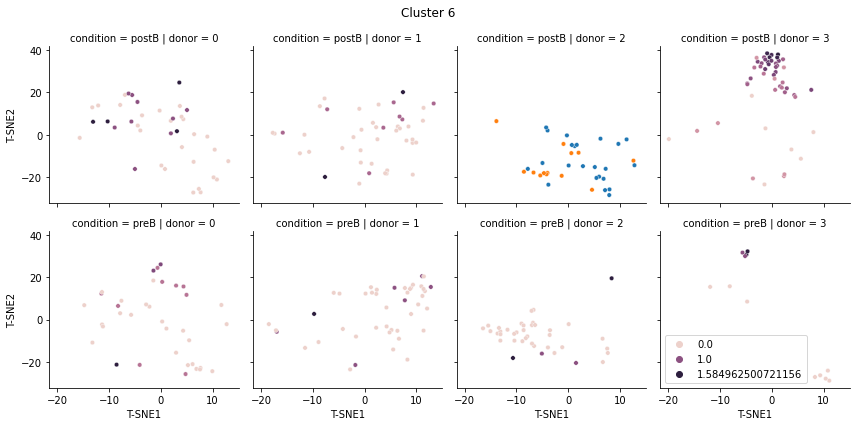

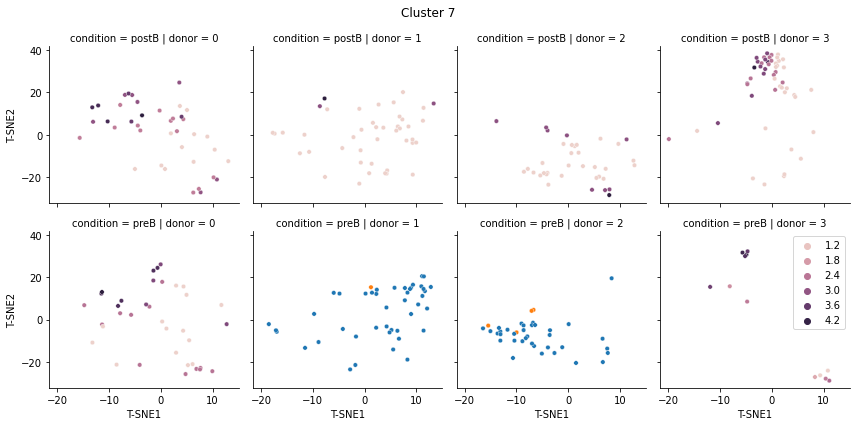

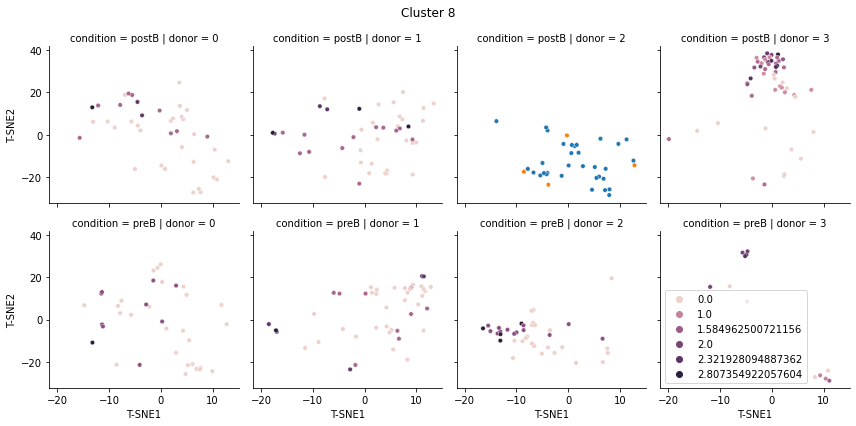

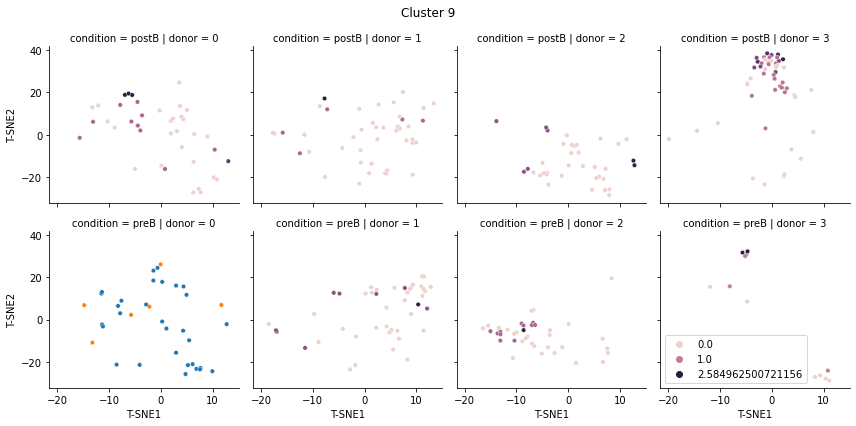

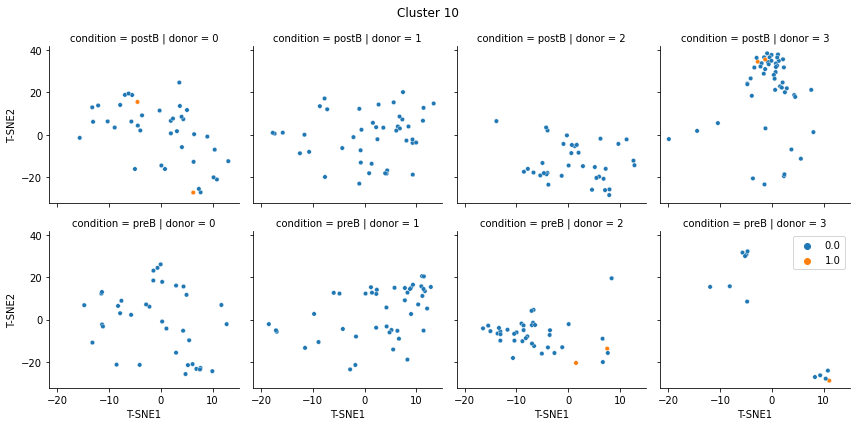

In [11]:
%matplotlib inline
log_outdir = join(outdir, "log2")
if not exists(log_outdir):
    os.mkdir(log_outdir)
    
X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=20,
                  init='random').fit_transform(clust_clones_counts_log.values)

tsne_df = pd.DataFrame(X_embedded, index=clust_clones_counts_log.index).rename({0:"T-SNE1",1:"T-SNE2"}, axis=1)
tsne_df

tsne_meta_df = pd.merge(tsne_df, meta, left_index=True, right_index=True)
sns.scatterplot(data=tsne_df, x="T-SNE1", y="T-SNE2")
tsne_meta_df

g = sns.FacetGrid(tsne_meta_df, col="donor",col_wrap=4)
g.map_dataframe(sns.scatterplot, x="T-SNE1", y="T-SNE2", hue="condition", s=20)
plt.legend()
plt.savefig(join(log_outdir, "umap.pdf"))

tsne_meta_features_df = pd.merge(tsne_meta_df, clust_clones_counts_log, left_index=True, right_index=True)
tsne_meta_features_df

for c in clust_clones_counts_log.columns:
    g = sns.FacetGrid(tsne_meta_features_df, row="condition", col="donor")
    g.map_dataframe(sns.scatterplot, x="T-SNE1", y="T-SNE2", hue=c, s=20)
    plt.suptitle(f"Cluster {c}")
    plt.tight_layout()
    plt.legend()
    plt.savefig(join(log_outdir, f"clust_{c}.png"))


# for c in clust_clones_counts_log.columns:
#     g = sns.FacetGrid(tsne_meta_features_df, col="condition", col_wrap=4)
#     g.map_dataframe(sns.scatterplot, x="T-SNE1", y="T-SNE2", hue=c, s=20)
#     plt.suptitle(f"Cluster {c}")
#     plt.tight_layout()
    plt.legend()

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


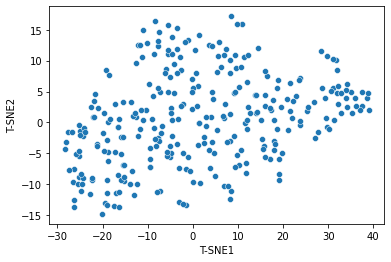

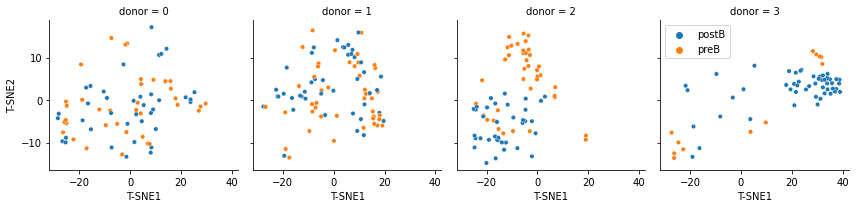

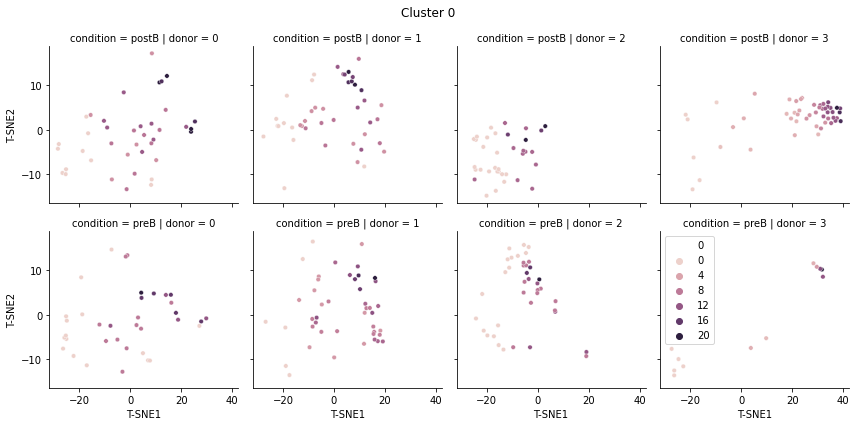

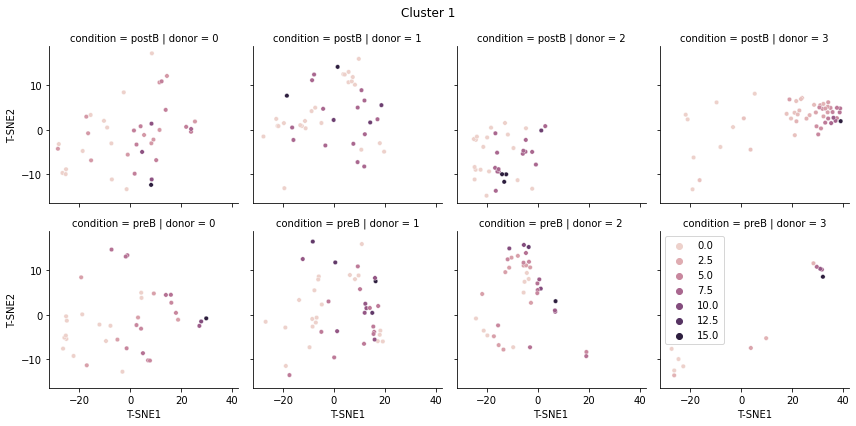

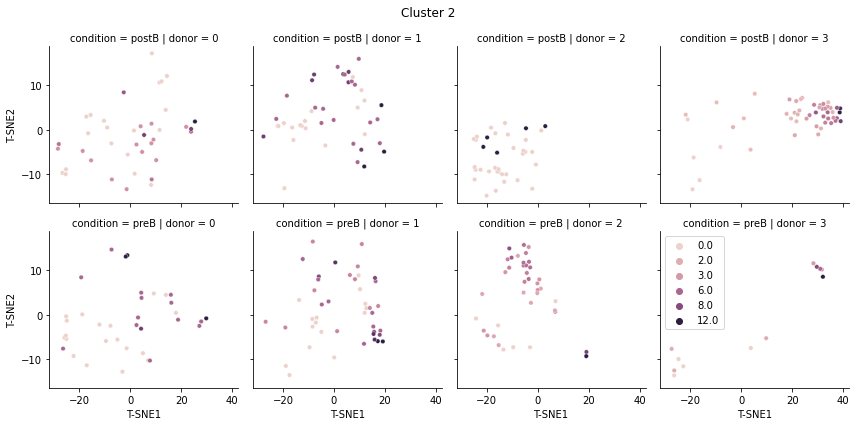

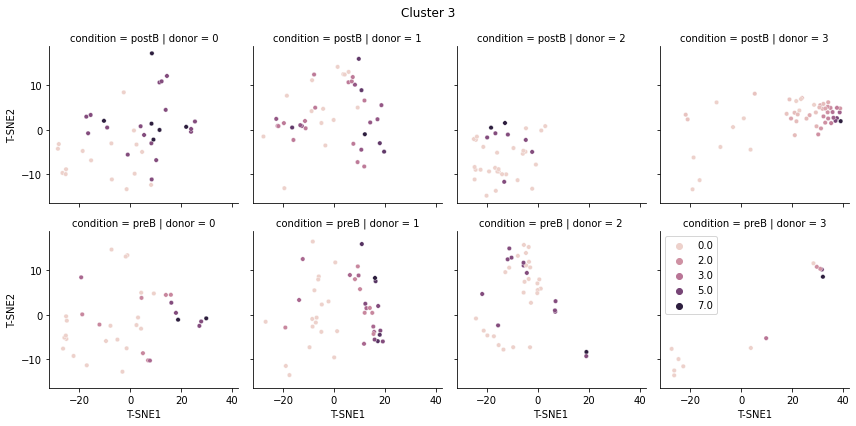

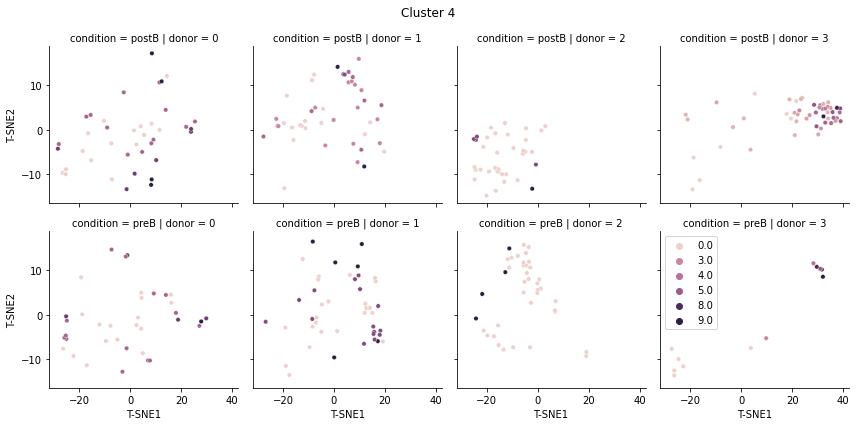

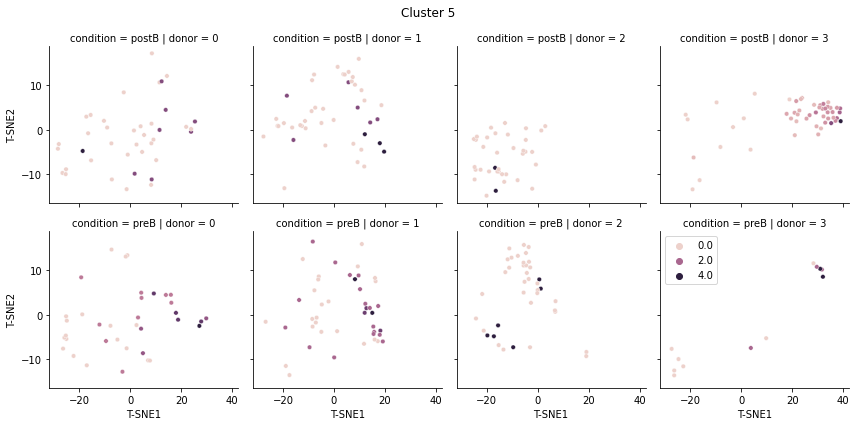

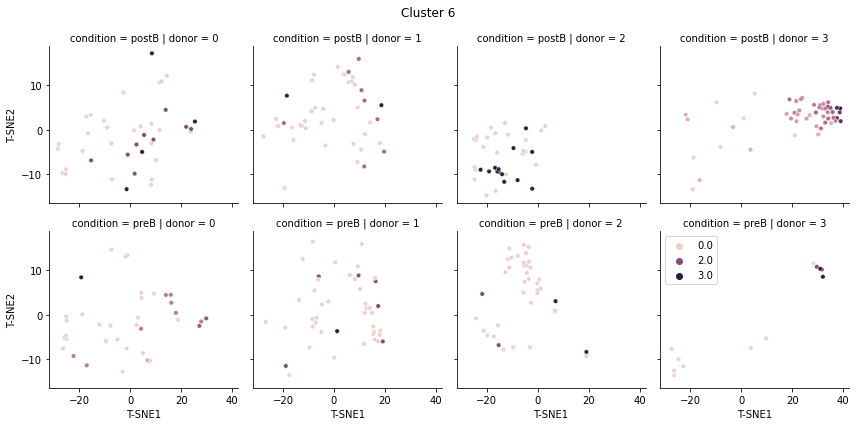

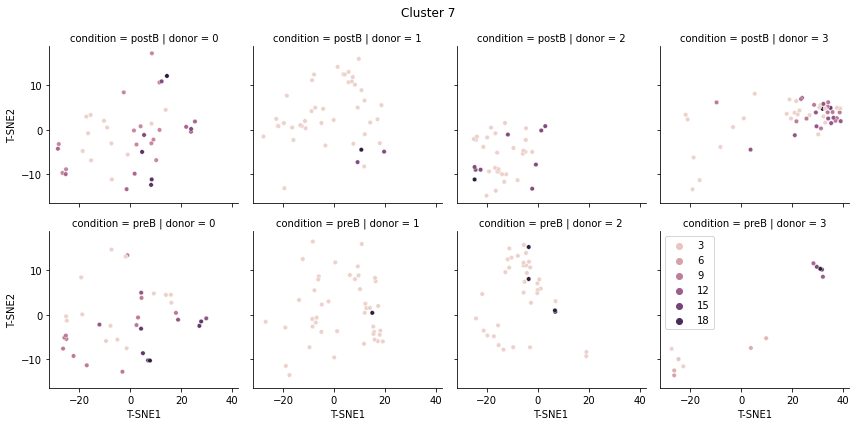

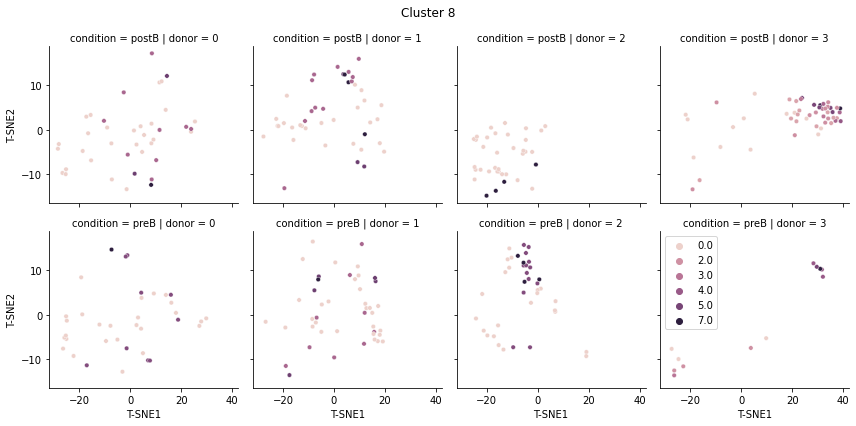

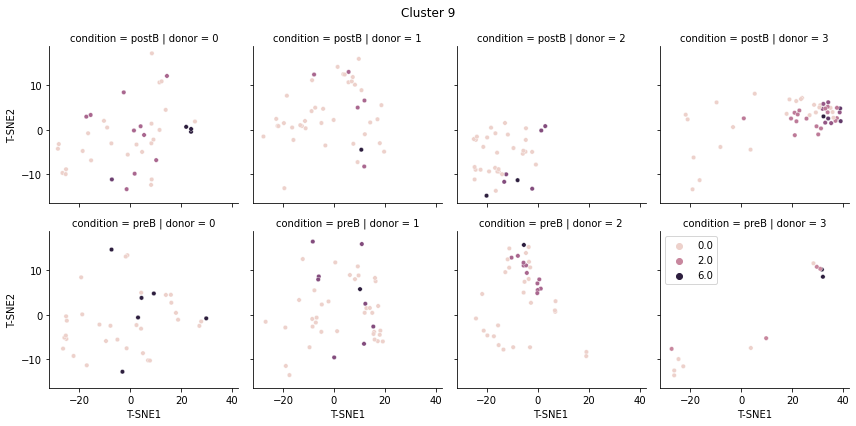

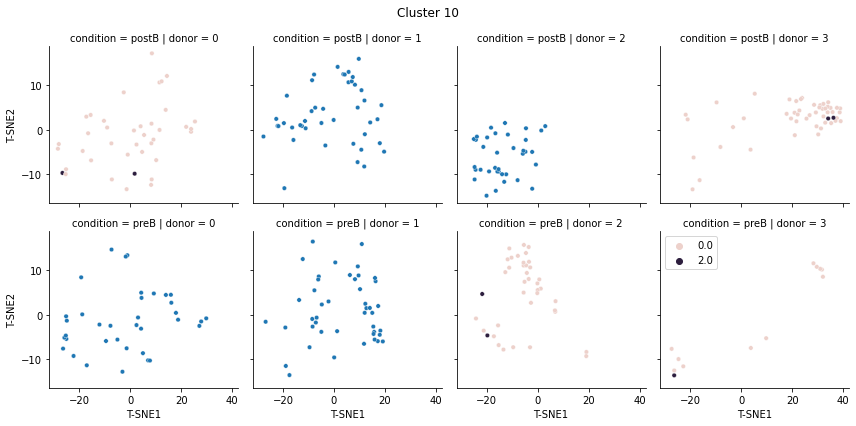

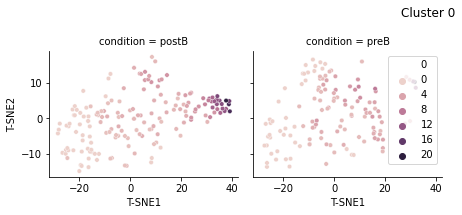

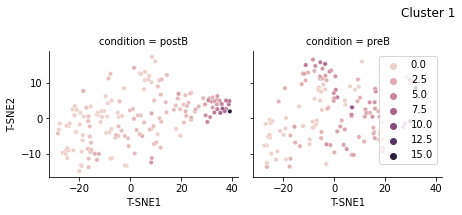

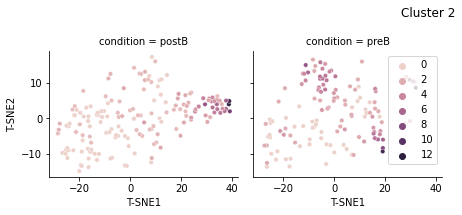

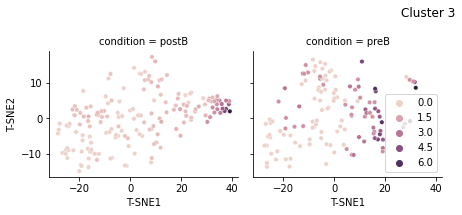

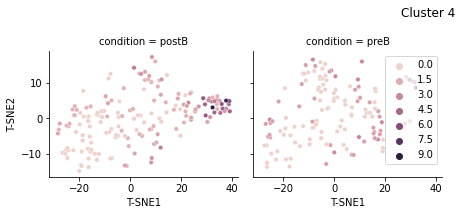

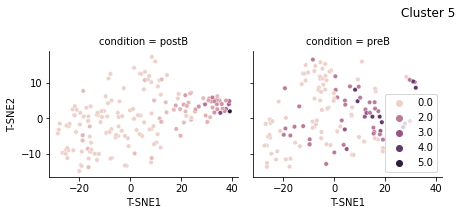

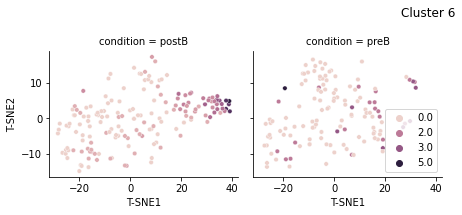

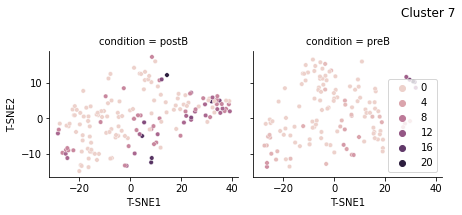

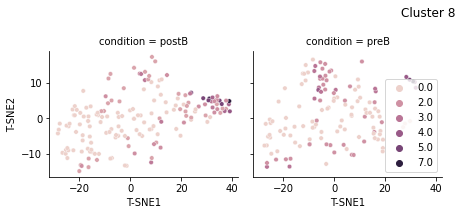

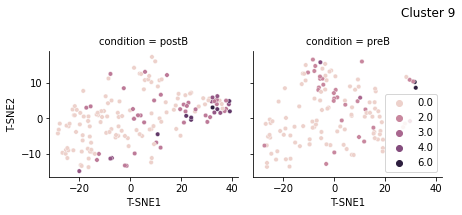

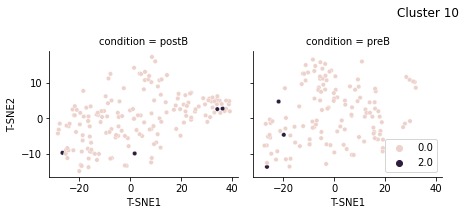

In [12]:
%matplotlib inline

X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=20,
                  init='random').fit_transform(clust_clones_counts.values)

tsne_df = pd.DataFrame(X_embedded, index=clust_clones_counts.index).rename({0:"T-SNE1",1:"T-SNE2"}, axis=1)
tsne_df

tsne_meta_df = pd.merge(tsne_df, meta, left_index=True, right_index=True)
sns.scatterplot(data=tsne_df, x="T-SNE1", y="T-SNE2")
tsne_meta_df

g = sns.FacetGrid(tsne_meta_df, col="donor",col_wrap=4)
g.map_dataframe(sns.scatterplot, x="T-SNE1", y="T-SNE2", hue="condition", s=20)
plt.legend()

tsne_meta_features_df = pd.merge(tsne_meta_df, clust_clones_counts, left_index=True, right_index=True)
tsne_meta_features_df


for c in clust_clones_counts.columns:
    g = sns.FacetGrid(tsne_meta_features_df, row="condition", col="donor")
    g.map_dataframe(sns.scatterplot, x="T-SNE1", y="T-SNE2", hue=c, s=20)
    plt.suptitle(f"Cluster {c}")
    plt.tight_layout()
    plt.legend()


for c in clust_clones_counts.columns:
    g = sns.FacetGrid(tsne_meta_features_df, col="condition", col_wrap=4)
    g.map_dataframe(sns.scatterplot, x="T-SNE1", y="T-SNE2", hue=c, s=20)
    plt.suptitle(f"Cluster {c}")
    plt.tight_layout()
    plt.legend()

## Run separate for each donor
(Just the norm)

In [13]:
clust_clones_counts_norm

seurat_clusters        0         1         2         3         4         5   \
ID                                                                            
0_0_postB        0.004717  0.001825  0.005123  0.001825  0.001825  0.001825   
0_0_preB         0.004525  0.005848  0.002262  0.004525  0.004525  0.004525   
0_10_postB       0.003650  0.002892  0.001825  0.001825  0.000000  0.000000   
0_10_preB        0.004525  0.003586  0.000000  0.004525  0.002262  0.004525   
0_11_postB       0.000000  0.005474  0.000000  0.000000  0.003650  0.000000   
...                   ...       ...       ...       ...       ...       ...   
3_5_postB        0.001771  0.001771  0.001471  0.001974  0.000885  0.001243   
3_6_preB         0.009434  0.010281  0.009434  0.007388  0.008342  0.005263   
3_7_postB        0.001638  0.001729  0.001403  0.001587  0.001243  0.001685   
3_8_postB        0.001729  0.001809  0.001144  0.001809  0.001328  0.000885   
3_9_postB        0.001809  0.001531  0.000702  0.001685  0.001403  0.001144   

seurat_clusters        6         7         8         9         10  
ID                                                                 
0_0_postB        0.002892  0.002892  0.000000  0.000000  0.000000  
0_0_preB         0.002262  0.004525  0.000000  0.000000  0.000000  
0_10_postB       0.000000  0.001825  0.000000  0.001825  0.000000  
0_10_preB        0.002262  0.002262  0.000000  0.000000  0.000000  
0_11_postB       0.000000  0.004237  0.003650  0.000000  0.000000  
...                   ...       ...       ...       ...       ...  
3_5_postB        0.001028  0.000443  0.001028  0.000443  0.000000  
3_6_preB         0.004171  0.009434  0.005263  0.006803  0.000000  
3_7_postB        0.000443  0.000702  0.000443  0.000702  0.000000  
3_8_postB        0.001144  0.000702  0.000443  0.000000  0.000443  
3_9_postB        0.001243  0.000443  0.001243  0.000000  0.000000  

[299 rows x 11 columns]

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


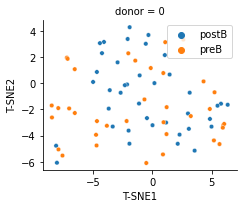

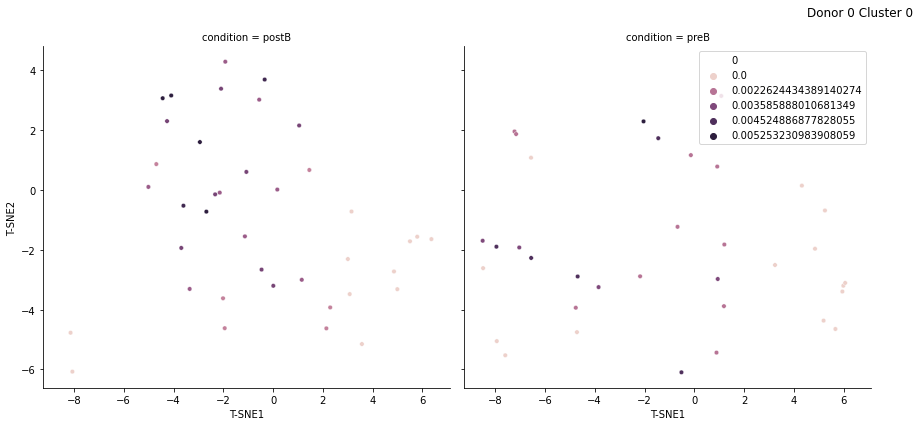

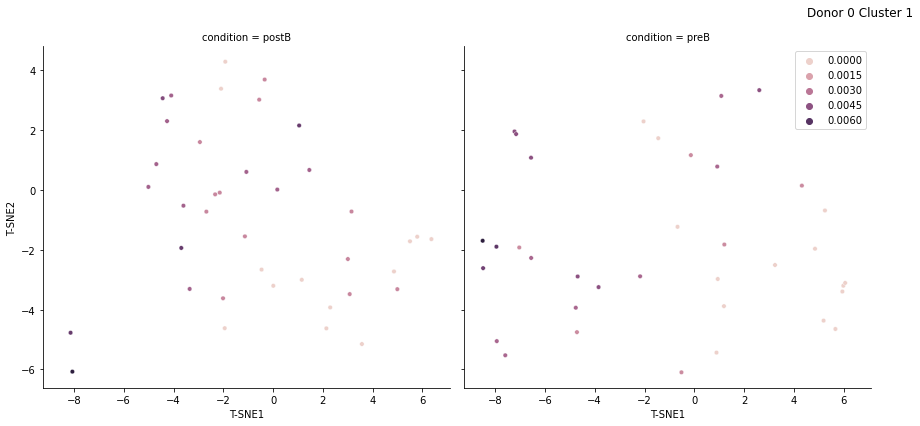

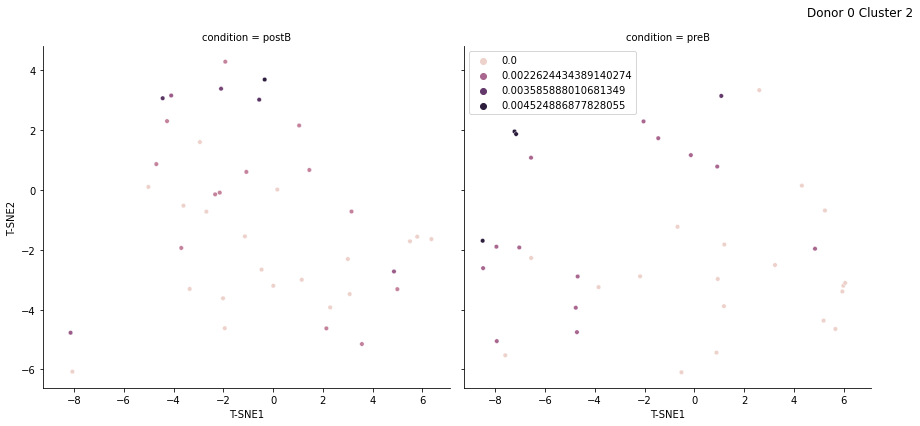

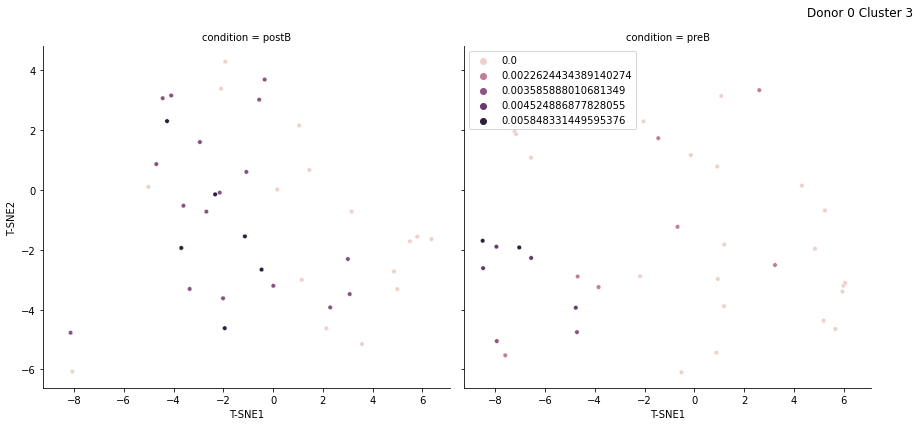

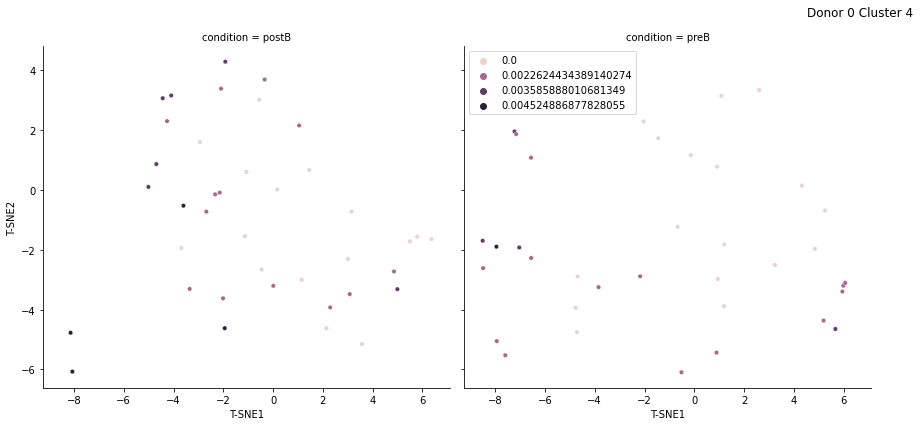

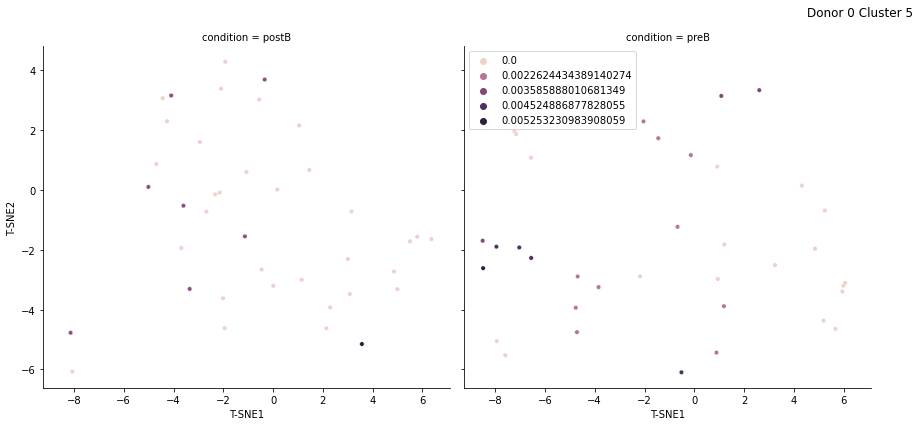

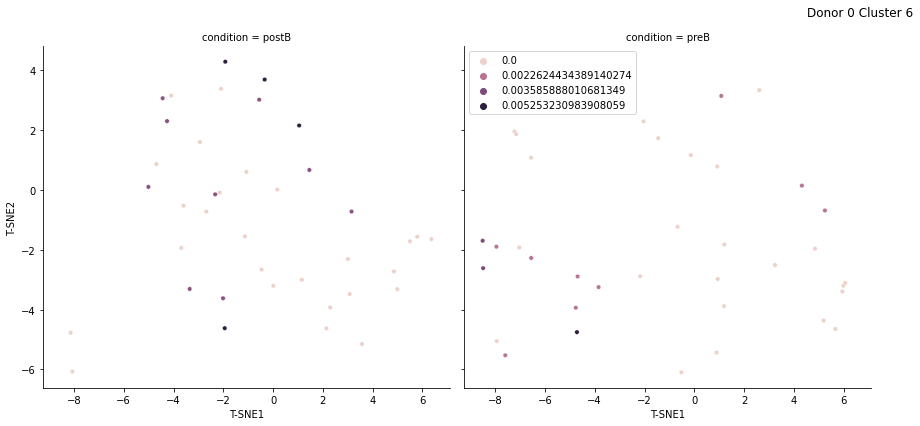

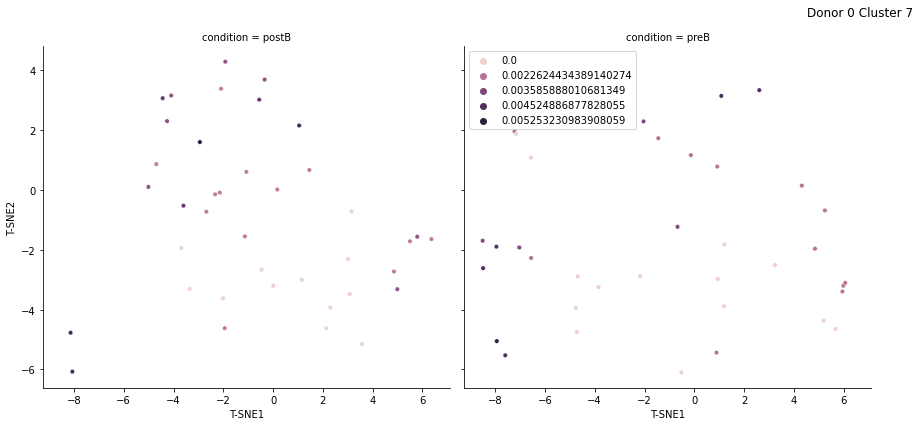

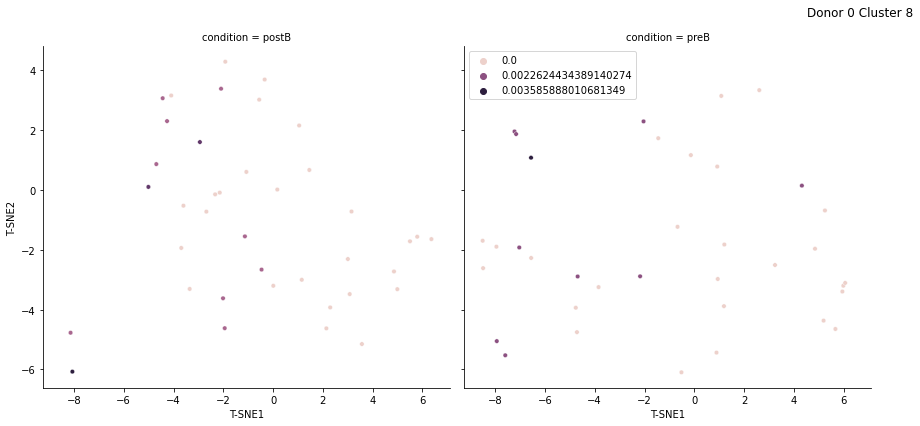

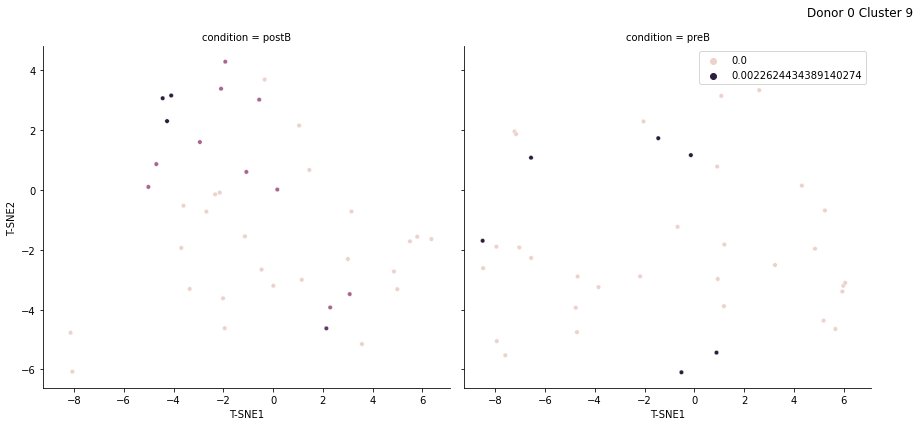

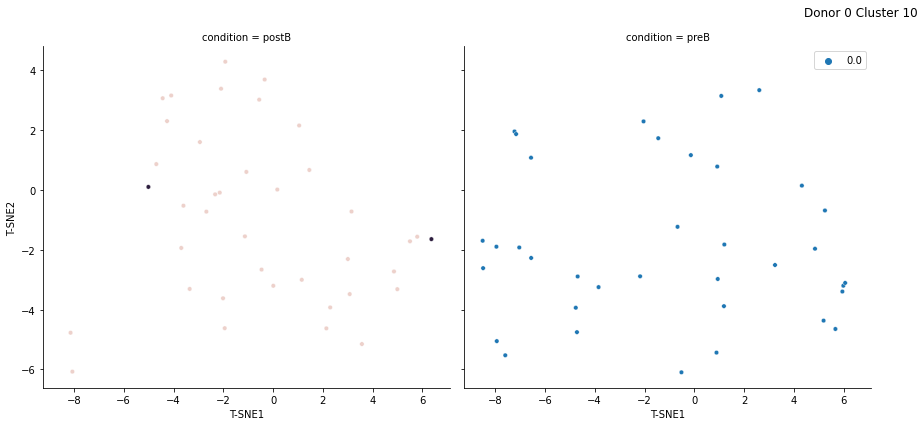

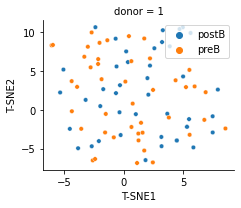

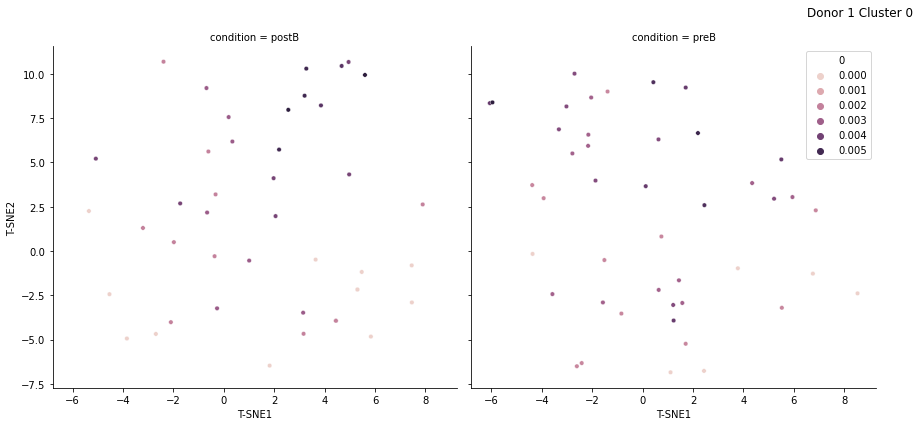

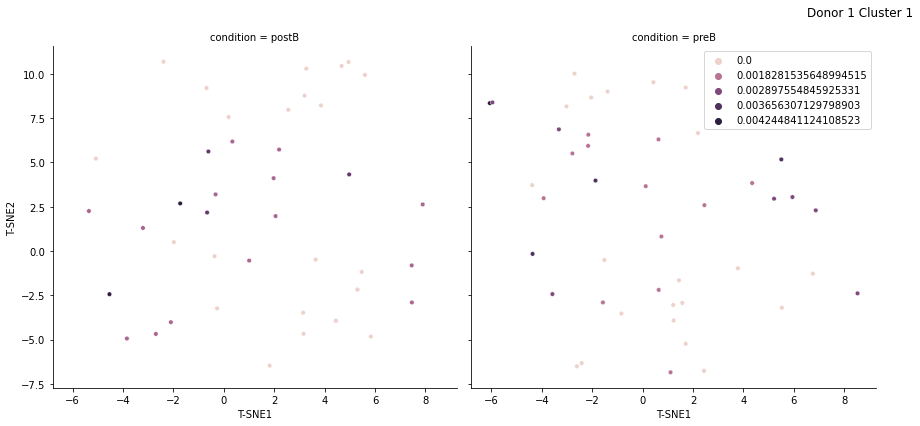

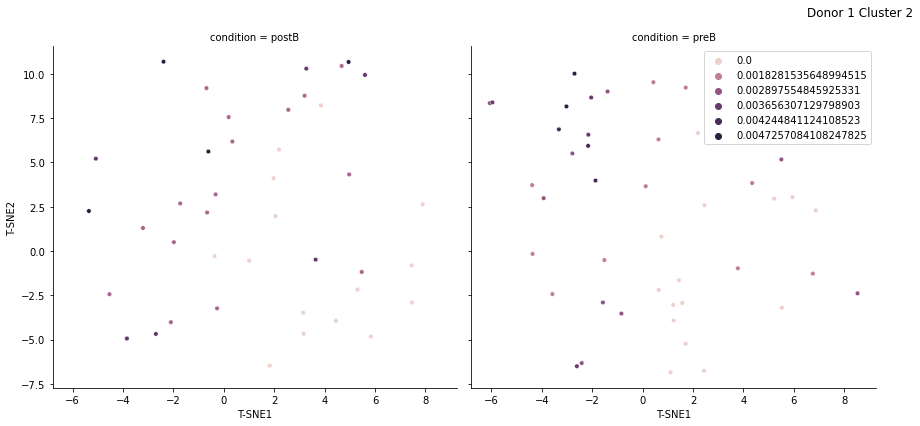

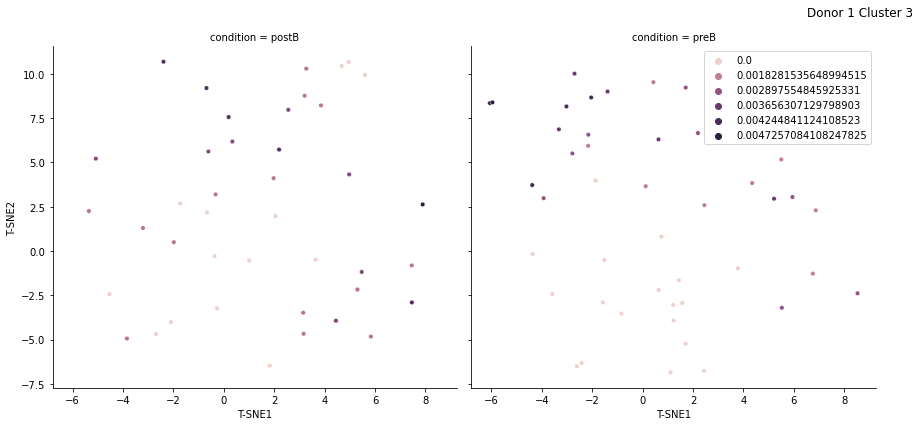

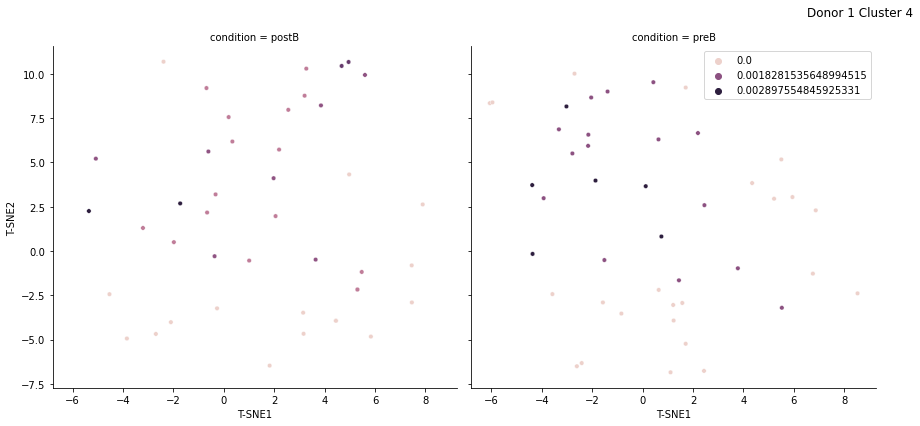

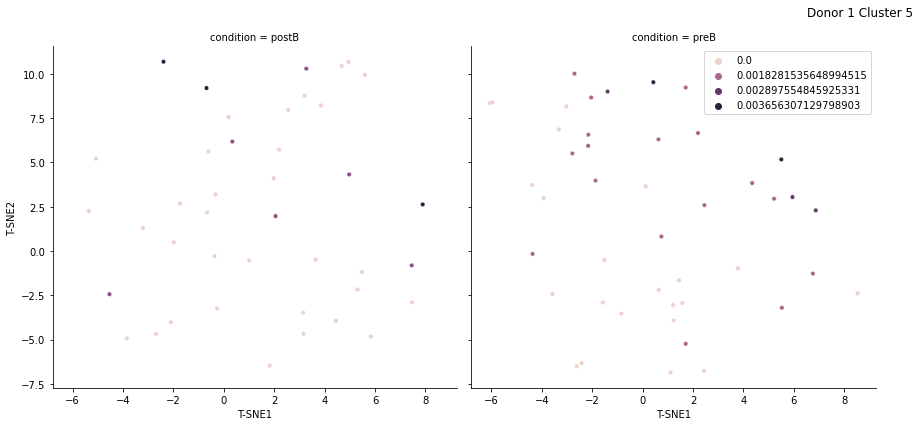

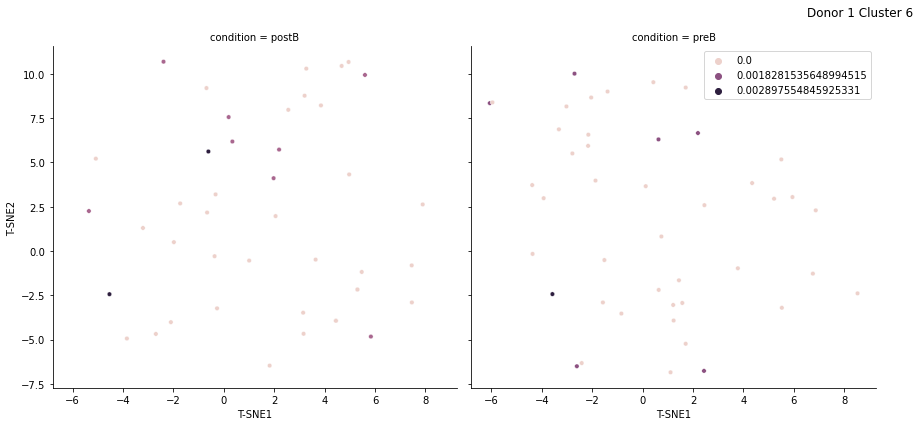

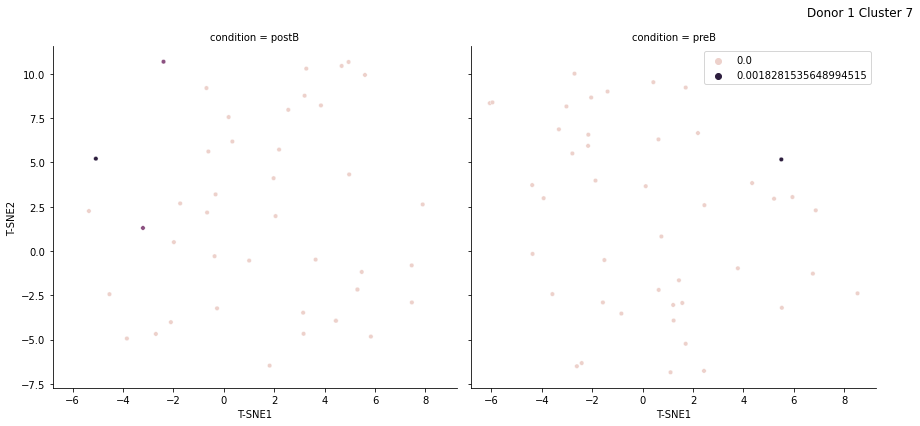

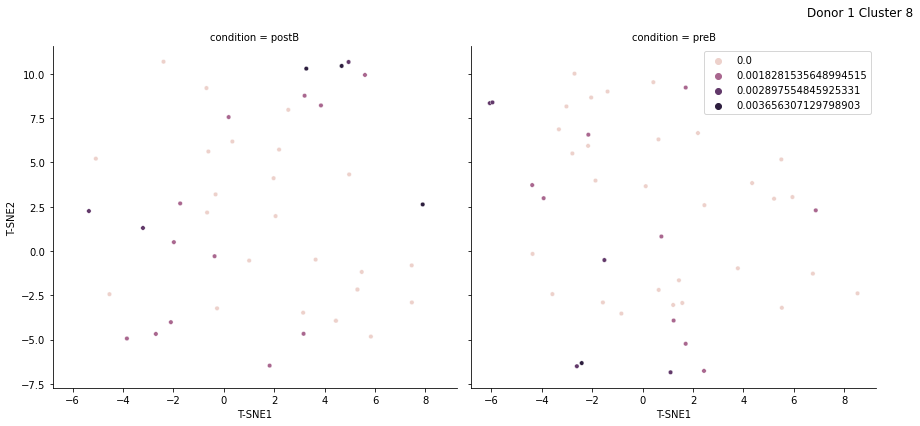

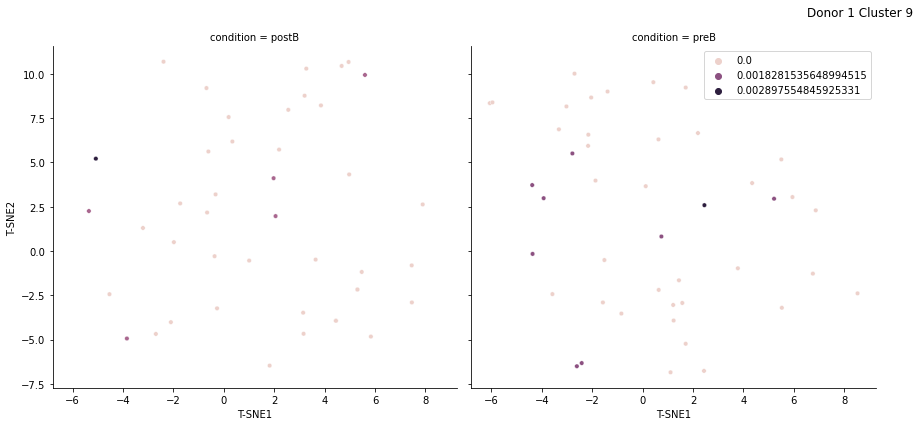

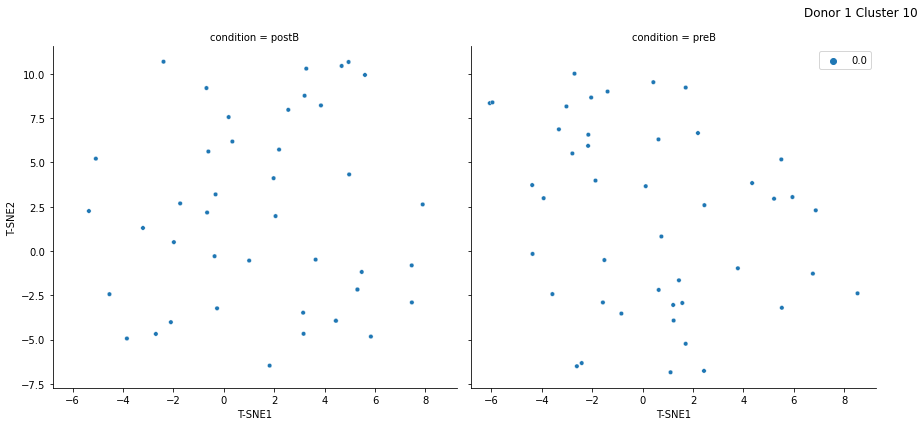

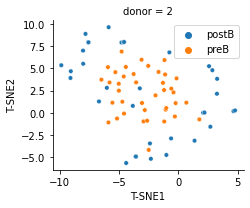

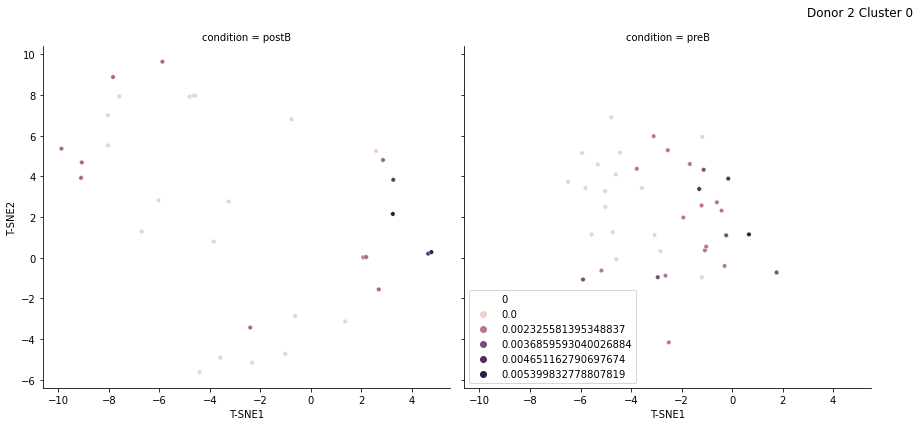

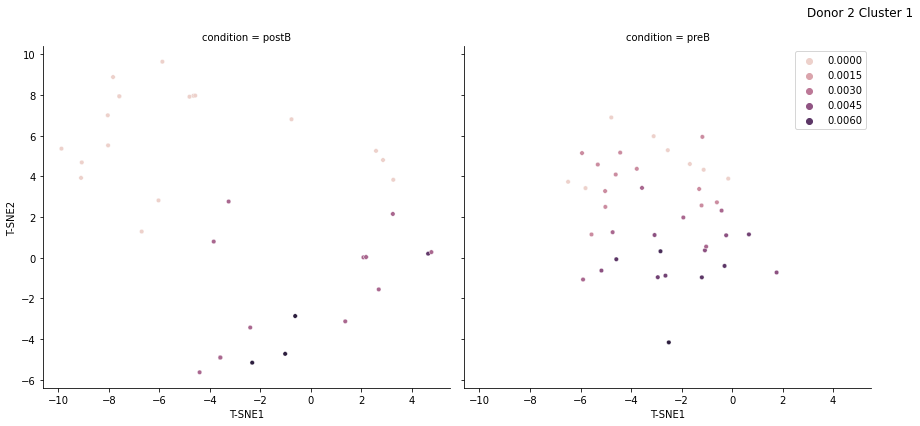

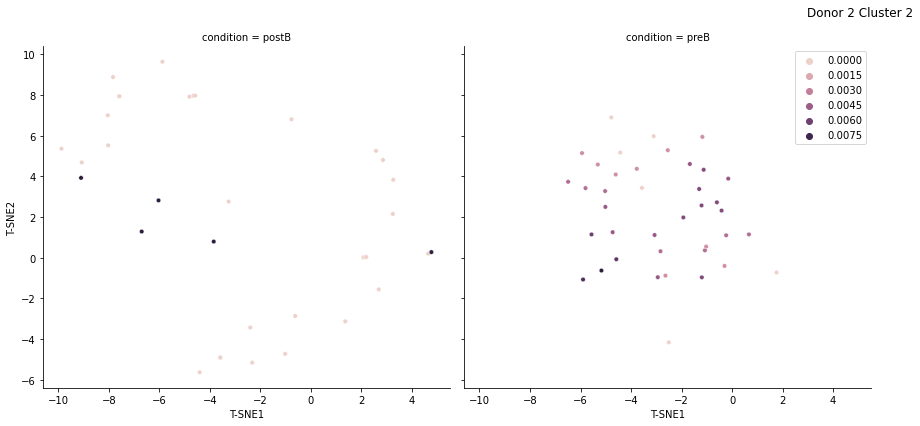

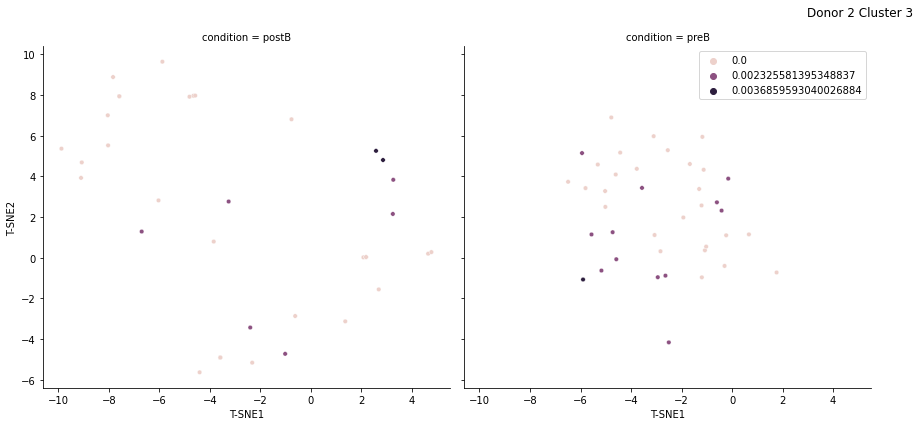

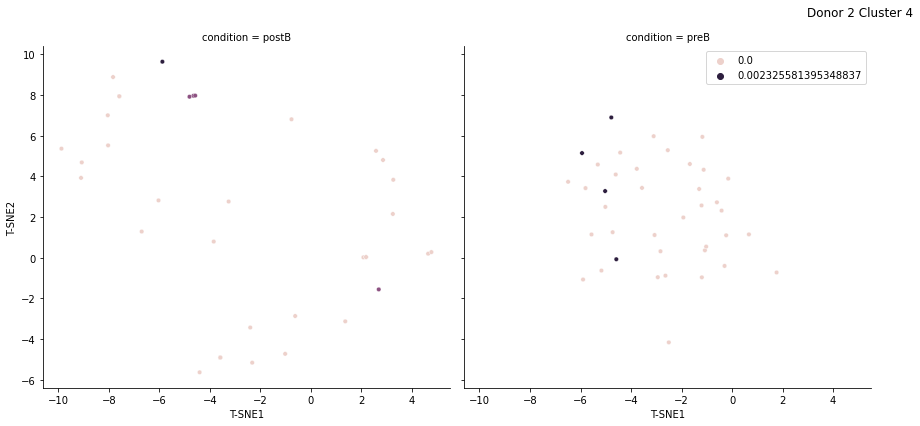

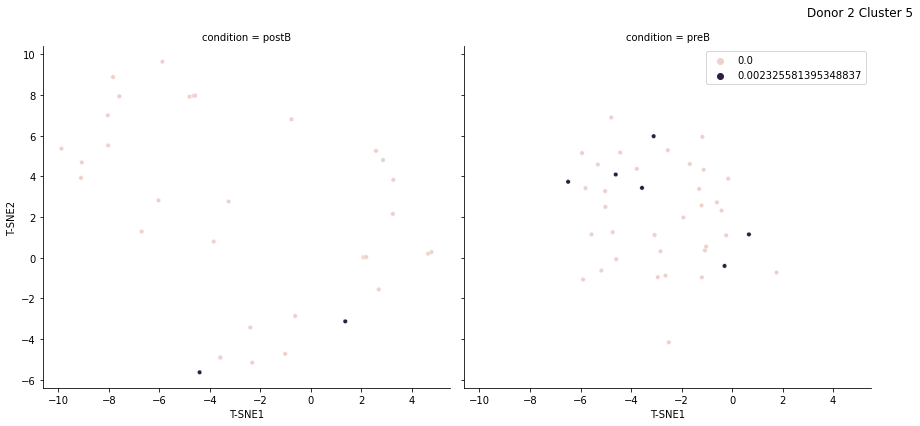

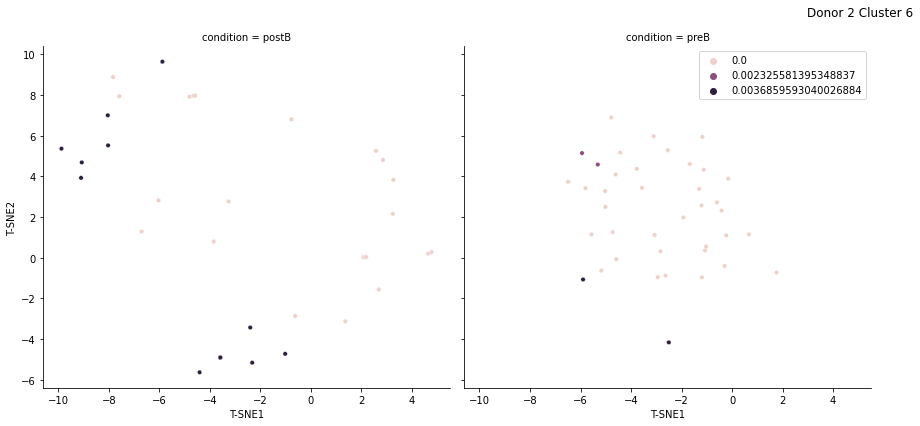

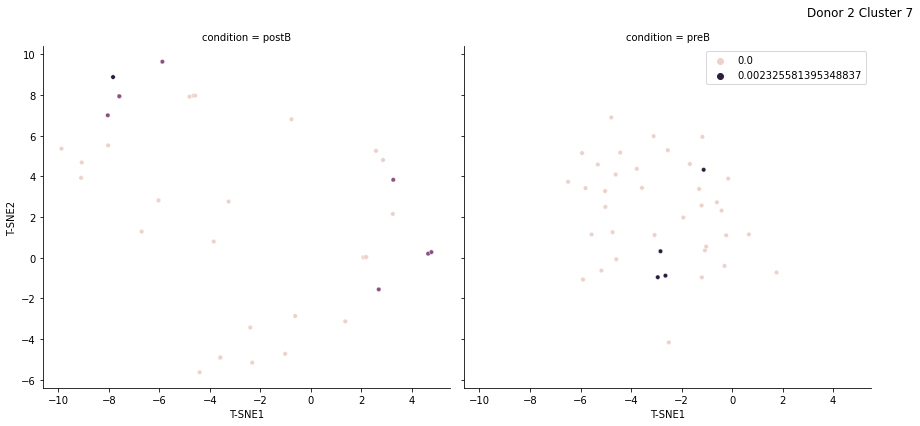

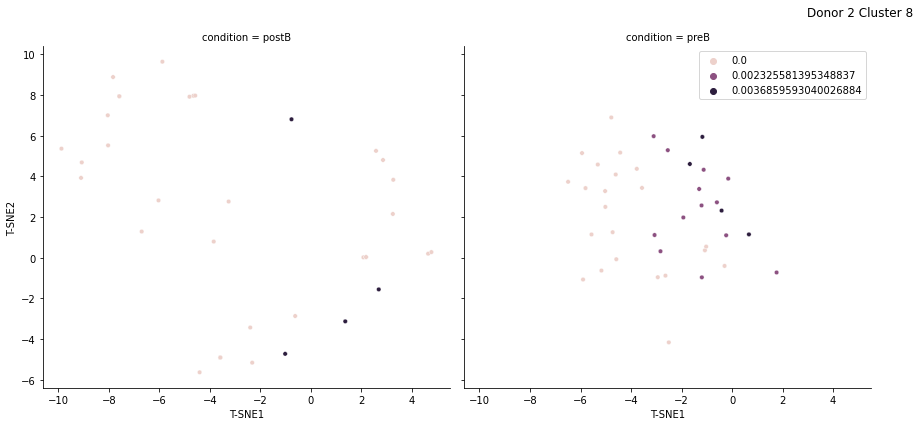

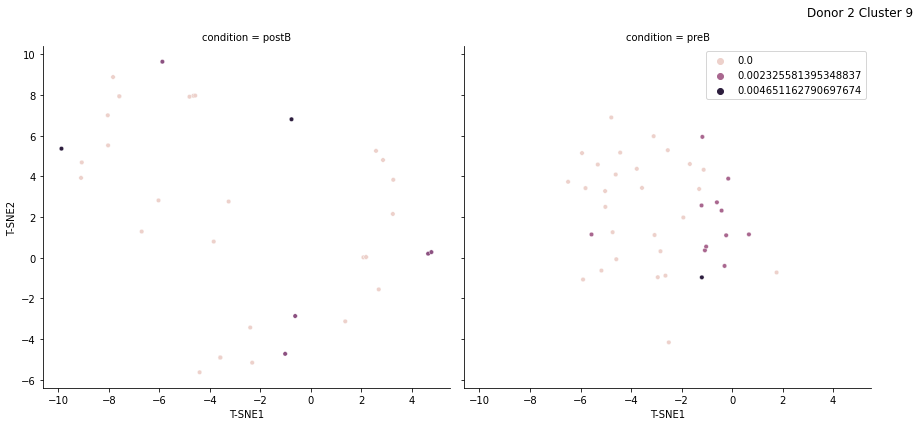

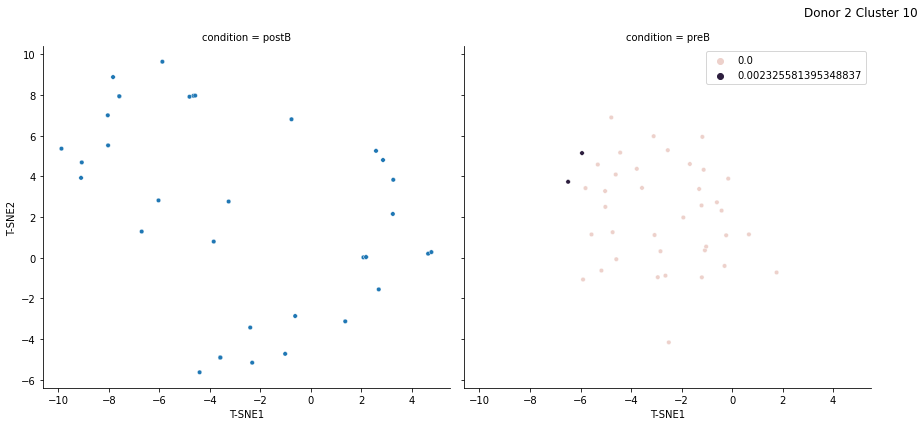

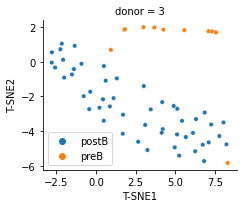

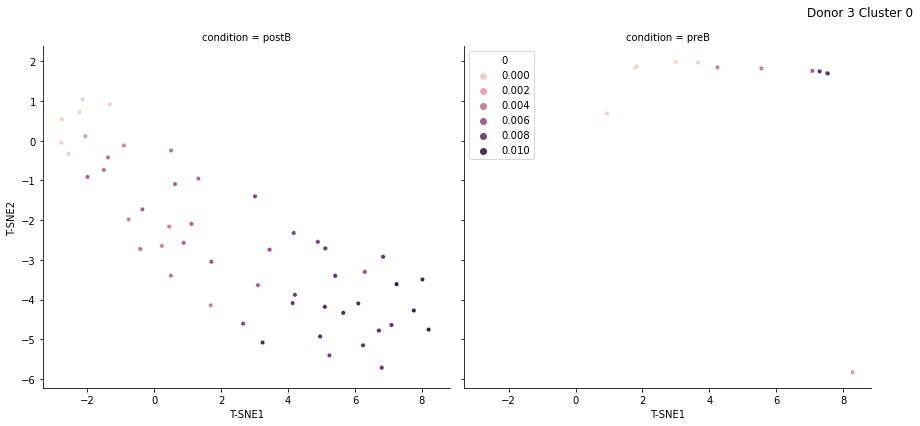

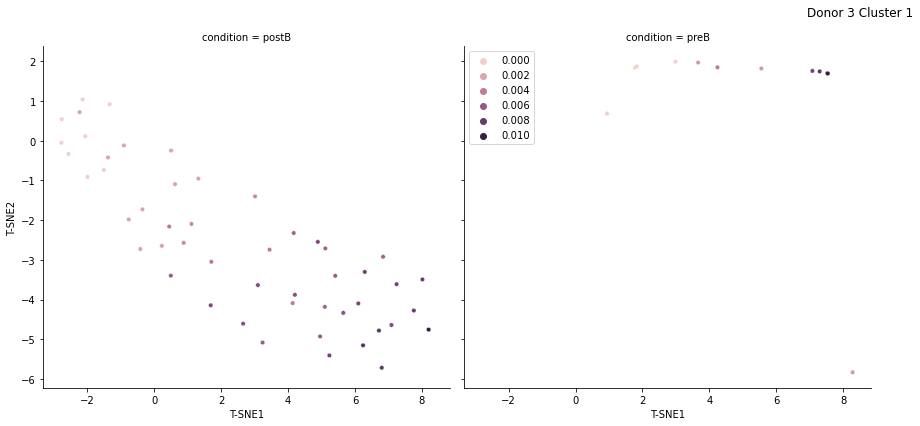

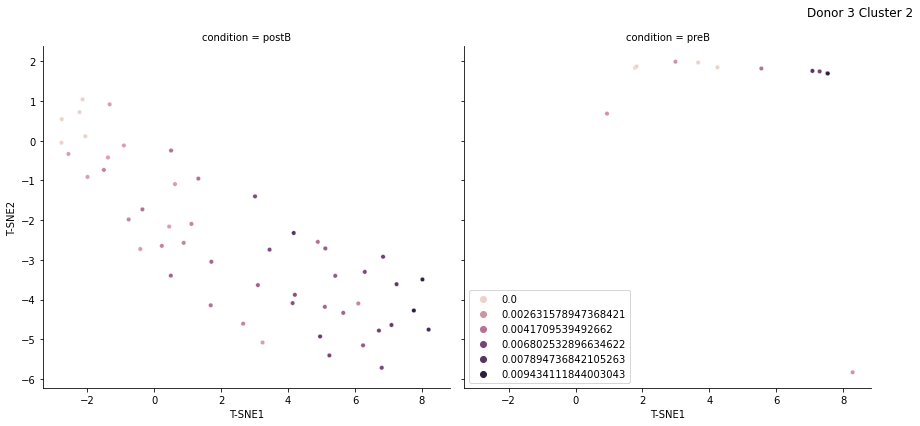

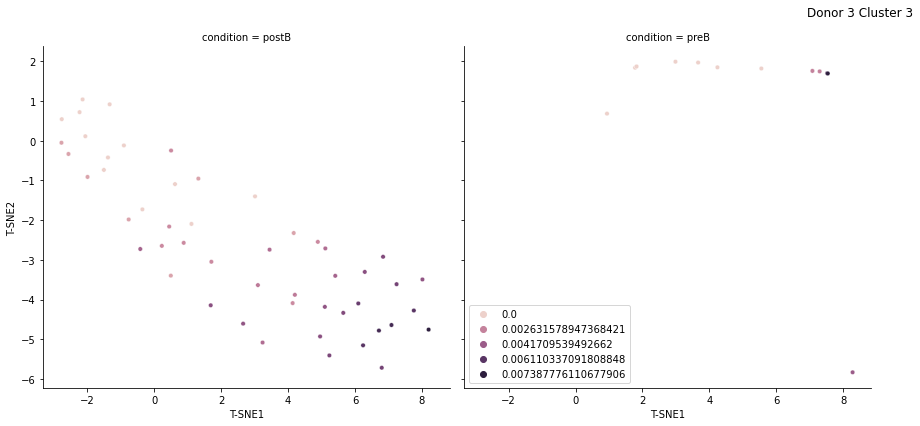

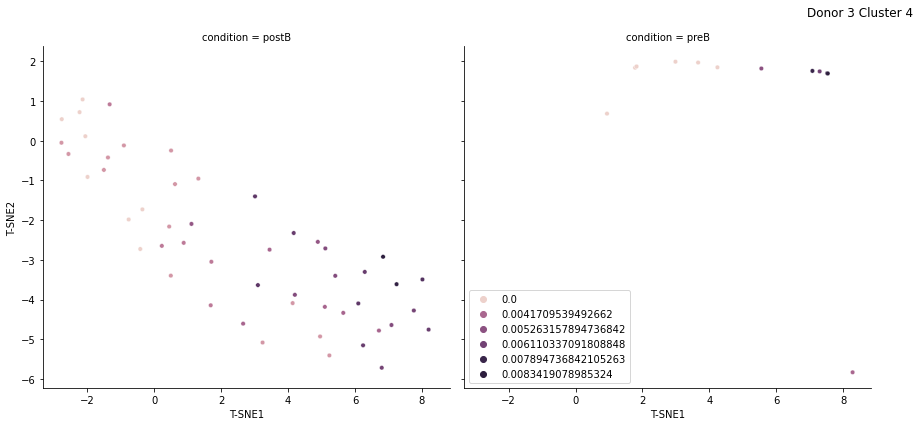

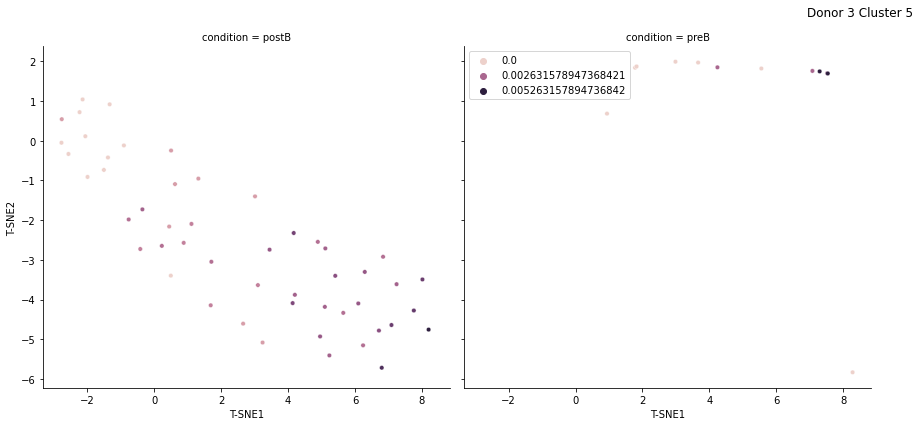

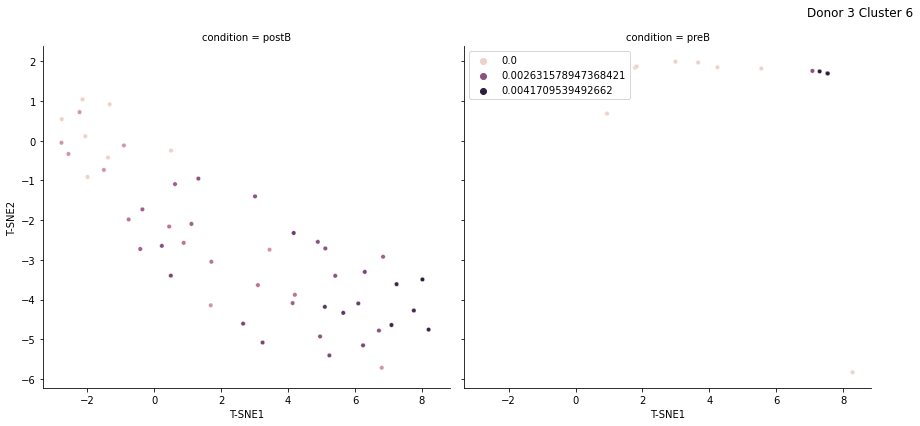

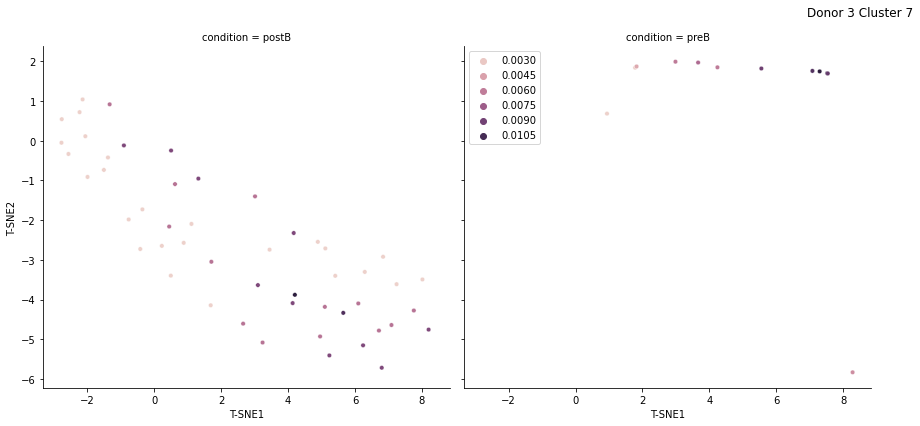

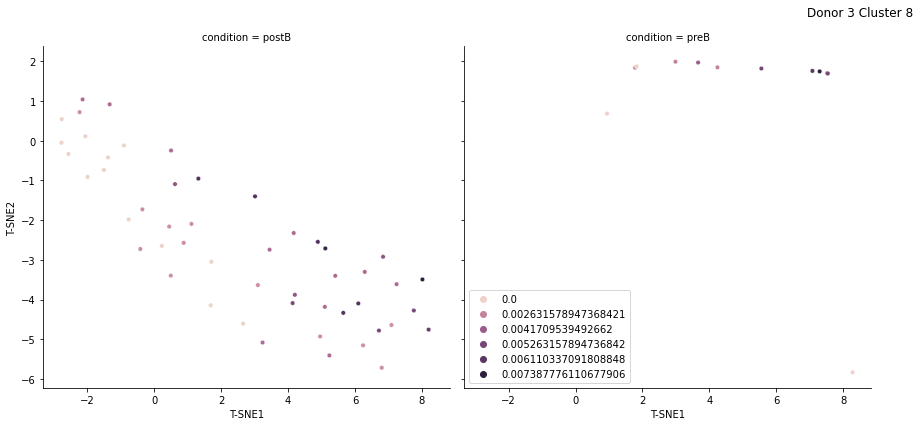

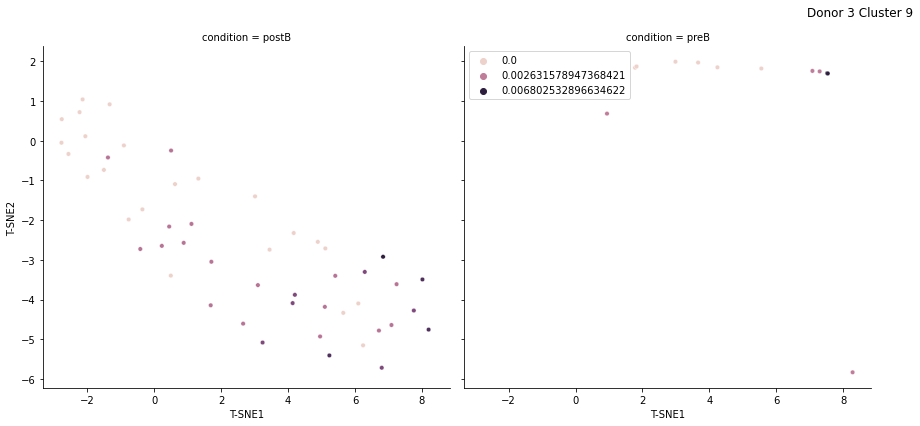

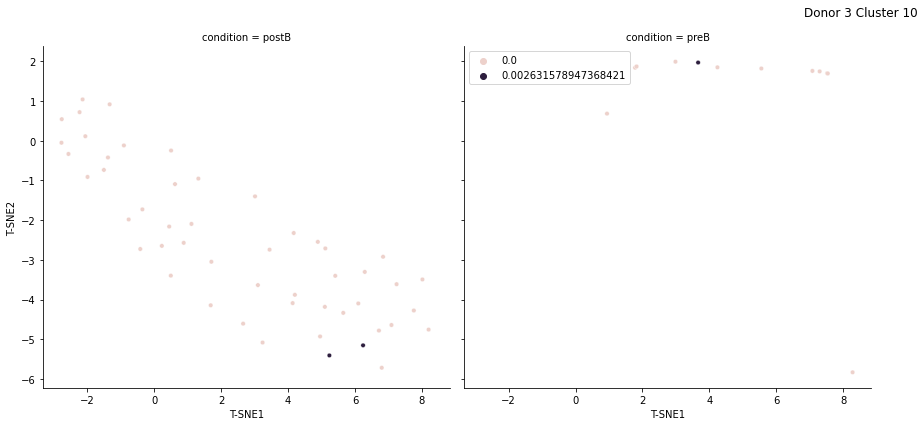

In [14]:
%matplotlib inline
for ind, val in meta.groupby("donor"):
    don_dir= join(outdir, f"donor_{ind}")
    if not exists(don_dir):
        os.mkdir(don_dir)
    curr = clust_clones_counts_norm.loc[val.index]
    
    X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=20,
                      init='random').fit_transform(curr.values)

    tsne_df = pd.DataFrame(X_embedded, index=curr.index).rename({0:"T-SNE1",1:"T-SNE2"}, axis=1)
    tsne_df
    tsne_meta_df = pd.merge(tsne_df, meta, left_index=True, right_index=True )


    g = sns.FacetGrid(tsne_meta_df, col="donor",col_wrap=4)
    g.map_dataframe(sns.scatterplot, x="T-SNE1", y="T-SNE2", hue="condition", s=20)
    plt.legend()
    plt.savefig(join(don_dir, "umap.pdf"))

    tsne_meta_features_df = pd.merge(tsne_meta_df, curr, left_index=True, right_index=True)
    tsne_meta_features_df
    
    for c in curr.columns:
        g = sns.FacetGrid(tsne_meta_features_df, col="condition", col_wrap=4, height=6)
        g.map_dataframe(sns.scatterplot, x="T-SNE1", y="T-SNE2", hue=c, s=20)
        plt.suptitle(f"Donor {ind} Cluster {c}")
        plt.tight_layout()
        plt.legend()
        plt.savefig(join(don_dir, f"clust_{c}.png"))
        